# deep_5 optimal model
# deep_res resnet and big generator
# deep_res_2 resnet and small generator


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import random
import pandas as pd
import time
import os
import math
from joblib import Parallel, delayed
import importlib
# tf.config.run_functions_eagerly(True)
%matplotlib inline

In [2]:
np.set_printoptions(suppress=True)

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [4]:
cd ../src

/home/rfit/Telescope_Array/Parameters_all/src


In [5]:
import reconstruction as reco

In [6]:

param_names=['signal','pl_fr','real_wf-pl_fr','mask']


In [7]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print('max_c,min_c',max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params

In [8]:
cd ../Notebooks/

/home/rfit/Telescope_Array/Parameters_all/Notebooks


In [82]:
#../../data_01_24.h5
# path='../../data_01_24.h5'
path = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl-sat_F_excl-geo_F_take-log-wf-False_bundled.h5'
num=200
with h5py.File(path,'r') as f:
    print(f.keys())
    data=f['dt_bunlde'][:num,:,:,3:7]
    print(data.shape)
    detectors_rub = f['dt_bunlde'][:num,:,:,:3] * 1.2 #/ 6 # norming
    real_ang = f['mc_params'][:num,4:6]
    recos = f['recos'][:num]
    dt_params =f['dt_params'][:num]
    ev_starts = f['ev_starts'][:num]
    dt_bunlde_mask = f['dt_bunlde_mask']
# norm_params=norming(data,log=False)
theta = tf.cast(real_ang[:,0:1]/180*3.1415,tf.float32)
phi = tf.cast(real_ang[:,1:2]/180*3.1415,tf.float32)
courve  = tf.cast(recos[:,6:7],tf.float32)
S800 = tf.cast(recos[:,2:3],tf.float32)
chi_rub = tf.cast(recos[:,5:6],tf.float32)

<KeysViewHDF5 ['det_max_params', 'det_max_wf', 'dt_bunlde', 'dt_bunlde_mask', 'dt_mask', 'dt_params', 'ev_ids', 'ev_starts', 'mc_params', 'recos', 'wfs_flat']>
(200, 6, 6, 4)


In [32]:
recos[0]

array([  39.2557  ,  114.024   ,    4.23001 ,    1.80164 ,    1.72568 ,
          2.27379 ,    0.912055,  126.121   , -111.443   ,    2.8966  ,
          2.95176 ,  140.65    ,    0.190525,   31.      ,    9.      ],
      dtype=float32)

In [10]:
def norming_params(param):
    t = tf.reduce_max(param)
    b = tf.reduce_min(param)
    param = (param-b)/(t-b)
    return param,t,b
def renorm_params(param,p_t,p_b):
    return param*(p_t-p_b)+p_b

In [11]:
# theta,theta_t,theta_b = norming_params(theta)
# phi,phi_t,phi_b = norming_params(phi)
# courve,courve_t,courve_b = norming_params(courve)
# S800,S800_t,S800_b = norming_params(S800) 
# theta.dtype,theta_t,theta_b 

In [48]:
all_data = list(zip(data,detectors_rub,theta,phi,courve,S800))
random.shuffle(all_data)
train = all_data[:172000]
test = all_data[172000:]
print(len(train),len(test))

172000 1044


# Optimization params of shower

In [54]:
cd ../src

/home/rfit/Telescope_Array/Parameters_all/src


In [83]:
importlib.reload(reco)

<module 'reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

In [84]:
chi_list, params_list = reco.optimization(data[:100],iterats=2000,num=None,detectors_rub=detectors_rub[:100])

tf.Tensor(91.60368, shape=(), dtype=float32) tf.Tensor(13781.848, shape=(), dtype=float32) tf.Tensor(13873.452, shape=(), dtype=float32)
tf.Tensor(91.048584, shape=(), dtype=float32) tf.Tensor(13743.12, shape=(), dtype=float32) tf.Tensor(13834.169, shape=(), dtype=float32)
tf.Tensor(90.497246, shape=(), dtype=float32) tf.Tensor(13704.441, shape=(), dtype=float32) tf.Tensor(13794.937, shape=(), dtype=float32)
tf.Tensor(89.94971, shape=(), dtype=float32) tf.Tensor(13665.781, shape=(), dtype=float32) tf.Tensor(13755.73, shape=(), dtype=float32)
tf.Tensor(89.406006, shape=(), dtype=float32) tf.Tensor(13627.168, shape=(), dtype=float32) tf.Tensor(13716.572, shape=(), dtype=float32)
tf.Tensor(88.86619, shape=(), dtype=float32) tf.Tensor(13588.551, shape=(), dtype=float32) tf.Tensor(13677.418, shape=(), dtype=float32)
tf.Tensor(88.33025, shape=(), dtype=float32) tf.Tensor(13549.996, shape=(), dtype=float32) tf.Tensor(13638.327, shape=(), dtype=float32)
tf.Tensor(87.79825, shape=(), dtype=floa

tf.Tensor(74.51283, shape=(), dtype=float32) tf.Tensor(12448.682, shape=(), dtype=float32) tf.Tensor(12523.195, shape=(), dtype=float32)
tf.Tensor(74.0936, shape=(), dtype=float32) tf.Tensor(12411.392, shape=(), dtype=float32) tf.Tensor(12485.483, shape=(), dtype=float32)
tf.Tensor(73.6779, shape=(), dtype=float32) tf.Tensor(12374.14, shape=(), dtype=float32) tf.Tensor(12447.817, shape=(), dtype=float32)
tf.Tensor(73.26573, shape=(), dtype=float32) tf.Tensor(12336.937, shape=(), dtype=float32) tf.Tensor(12410.2, shape=(), dtype=float32)
tf.Tensor(72.85705, shape=(), dtype=float32) tf.Tensor(12299.787, shape=(), dtype=float32) tf.Tensor(12372.644, shape=(), dtype=float32)
tf.Tensor(72.45183, shape=(), dtype=float32) tf.Tensor(12262.695, shape=(), dtype=float32) tf.Tensor(12335.147, shape=(), dtype=float32)
tf.Tensor(72.050026, shape=(), dtype=float32) tf.Tensor(12225.633, shape=(), dtype=float32) tf.Tensor(12297.6875, shape=(), dtype=float32)
tf.Tensor(71.65161, shape=(), dtype=float32)

tf.Tensor(61.436142, shape=(), dtype=float32) tf.Tensor(11137.361, shape=(), dtype=float32) tf.Tensor(11198.796, shape=(), dtype=float32)
tf.Tensor(61.125507, shape=(), dtype=float32) tf.Tensor(11101.834, shape=(), dtype=float32) tf.Tensor(11162.96, shape=(), dtype=float32)
tf.Tensor(60.817368, shape=(), dtype=float32) tf.Tensor(11066.379, shape=(), dtype=float32) tf.Tensor(11127.196, shape=(), dtype=float32)
tf.Tensor(60.511684, shape=(), dtype=float32) tf.Tensor(11030.946, shape=(), dtype=float32) tf.Tensor(11091.459, shape=(), dtype=float32)
tf.Tensor(60.208447, shape=(), dtype=float32) tf.Tensor(10995.575, shape=(), dtype=float32) tf.Tensor(11055.784, shape=(), dtype=float32)
tf.Tensor(59.90761, shape=(), dtype=float32) tf.Tensor(10960.246, shape=(), dtype=float32) tf.Tensor(11020.155, shape=(), dtype=float32)
tf.Tensor(59.60917, shape=(), dtype=float32) tf.Tensor(10924.969, shape=(), dtype=float32) tf.Tensor(10984.577, shape=(), dtype=float32)
tf.Tensor(59.313087, shape=(), dtype=

tf.Tensor(51.890816, shape=(), dtype=float32) tf.Tensor(9920.705, shape=(), dtype=float32) tf.Tensor(9972.597, shape=(), dtype=float32)
tf.Tensor(51.65382, shape=(), dtype=float32) tf.Tensor(9886.71, shape=(), dtype=float32) tf.Tensor(9938.363, shape=(), dtype=float32)
tf.Tensor(51.418583, shape=(), dtype=float32) tf.Tensor(9852.747, shape=(), dtype=float32) tf.Tensor(9904.167, shape=(), dtype=float32)
tf.Tensor(51.185078, shape=(), dtype=float32) tf.Tensor(9818.827, shape=(), dtype=float32) tf.Tensor(9870.012, shape=(), dtype=float32)
tf.Tensor(50.953312, shape=(), dtype=float32) tf.Tensor(9784.946, shape=(), dtype=float32) tf.Tensor(9835.898, shape=(), dtype=float32)
tf.Tensor(50.723244, shape=(), dtype=float32) tf.Tensor(9751.109, shape=(), dtype=float32) tf.Tensor(9801.832, shape=(), dtype=float32)
tf.Tensor(50.494873, shape=(), dtype=float32) tf.Tensor(9717.306, shape=(), dtype=float32) tf.Tensor(9767.8, shape=(), dtype=float32)
tf.Tensor(50.26819, shape=(), dtype=float32) tf.Tens

tf.Tensor(44.36349, shape=(), dtype=float32) tf.Tensor(8722.968, shape=(), dtype=float32) tf.Tensor(8767.332, shape=(), dtype=float32)
tf.Tensor(44.18098, shape=(), dtype=float32) tf.Tensor(8690.513, shape=(), dtype=float32) tf.Tensor(8734.695, shape=(), dtype=float32)
tf.Tensor(43.999756, shape=(), dtype=float32) tf.Tensor(8658.119, shape=(), dtype=float32) tf.Tensor(8702.121, shape=(), dtype=float32)
tf.Tensor(43.819813, shape=(), dtype=float32) tf.Tensor(8625.762, shape=(), dtype=float32) tf.Tensor(8669.582, shape=(), dtype=float32)
tf.Tensor(43.641148, shape=(), dtype=float32) tf.Tensor(8593.46, shape=(), dtype=float32) tf.Tensor(8637.101, shape=(), dtype=float32)
tf.Tensor(43.463745, shape=(), dtype=float32) tf.Tensor(8561.211, shape=(), dtype=float32) tf.Tensor(8604.675, shape=(), dtype=float32)
tf.Tensor(43.287582, shape=(), dtype=float32) tf.Tensor(8529.003, shape=(), dtype=float32) tf.Tensor(8572.292, shape=(), dtype=float32)
tf.Tensor(43.112656, shape=(), dtype=float32) tf.Te

tf.Tensor(38.535683, shape=(), dtype=float32) tf.Tensor(7588.0933, shape=(), dtype=float32) tf.Tensor(7626.629, shape=(), dtype=float32)
tf.Tensor(38.39359, shape=(), dtype=float32) tf.Tensor(7557.6455, shape=(), dtype=float32) tf.Tensor(7596.038, shape=(), dtype=float32)
tf.Tensor(38.252472, shape=(), dtype=float32) tf.Tensor(7527.2524, shape=(), dtype=float32) tf.Tensor(7565.505, shape=(), dtype=float32)
tf.Tensor(38.11231, shape=(), dtype=float32) tf.Tensor(7496.9326, shape=(), dtype=float32) tf.Tensor(7535.045, shape=(), dtype=float32)
tf.Tensor(37.973095, shape=(), dtype=float32) tf.Tensor(7466.6646, shape=(), dtype=float32) tf.Tensor(7504.6377, shape=(), dtype=float32)
tf.Tensor(37.834816, shape=(), dtype=float32) tf.Tensor(7436.4727, shape=(), dtype=float32) tf.Tensor(7474.3086, shape=(), dtype=float32)
tf.Tensor(37.697464, shape=(), dtype=float32) tf.Tensor(7406.3276, shape=(), dtype=float32) tf.Tensor(7444.0264, shape=(), dtype=float32)
tf.Tensor(37.56105, shape=(), dtype=floa

tf.Tensor(34.088627, shape=(), dtype=float32) tf.Tensor(6562.315, shape=(), dtype=float32) tf.Tensor(6596.4043, shape=(), dtype=float32)
tf.Tensor(33.97605, shape=(), dtype=float32) tf.Tensor(6534.292, shape=(), dtype=float32) tf.Tensor(6568.268, shape=(), dtype=float32)
tf.Tensor(33.8642, shape=(), dtype=float32) tf.Tensor(6506.3477, shape=(), dtype=float32) tf.Tensor(6540.2124, shape=(), dtype=float32)
tf.Tensor(33.753075, shape=(), dtype=float32) tf.Tensor(6478.476, shape=(), dtype=float32) tf.Tensor(6512.2295, shape=(), dtype=float32)
tf.Tensor(33.642654, shape=(), dtype=float32) tf.Tensor(6450.688, shape=(), dtype=float32) tf.Tensor(6484.3296, shape=(), dtype=float32)
tf.Tensor(33.53295, shape=(), dtype=float32) tf.Tensor(6422.9663, shape=(), dtype=float32) tf.Tensor(6456.498, shape=(), dtype=float32)
tf.Tensor(33.423946, shape=(), dtype=float32) tf.Tensor(6395.3276, shape=(), dtype=float32) tf.Tensor(6428.7505, shape=(), dtype=float32)
tf.Tensor(33.315643, shape=(), dtype=float32

tf.Tensor(30.455294, shape=(), dtype=float32) tf.Tensor(5602.788, shape=(), dtype=float32) tf.Tensor(5633.2437, shape=(), dtype=float32)
tf.Tensor(30.36559, shape=(), dtype=float32) tf.Tensor(5577.6265, shape=(), dtype=float32) tf.Tensor(5607.9927, shape=(), dtype=float32)
tf.Tensor(30.27643, shape=(), dtype=float32) tf.Tensor(5552.5474, shape=(), dtype=float32) tf.Tensor(5582.824, shape=(), dtype=float32)
tf.Tensor(30.18782, shape=(), dtype=float32) tf.Tensor(5527.5513, shape=(), dtype=float32) tf.Tensor(5557.7393, shape=(), dtype=float32)
tf.Tensor(30.099749, shape=(), dtype=float32) tf.Tensor(5502.6343, shape=(), dtype=float32) tf.Tensor(5532.735, shape=(), dtype=float32)
tf.Tensor(30.012207, shape=(), dtype=float32) tf.Tensor(5477.806, shape=(), dtype=float32) tf.Tensor(5507.819, shape=(), dtype=float32)
tf.Tensor(29.925205, shape=(), dtype=float32) tf.Tensor(5453.0586, shape=(), dtype=float32) tf.Tensor(5482.984, shape=(), dtype=float32)
tf.Tensor(29.838736, shape=(), dtype=float3

tf.Tensor(27.629356, shape=(), dtype=float32) tf.Tensor(4771.8853, shape=(), dtype=float32) tf.Tensor(4799.514, shape=(), dtype=float32)
tf.Tensor(27.556725, shape=(), dtype=float32) tf.Tensor(4749.6655, shape=(), dtype=float32) tf.Tensor(4777.2227, shape=(), dtype=float32)
tf.Tensor(27.484482, shape=(), dtype=float32) tf.Tensor(4727.523, shape=(), dtype=float32) tf.Tensor(4755.0073, shape=(), dtype=float32)
tf.Tensor(27.412725, shape=(), dtype=float32) tf.Tensor(4705.4736, shape=(), dtype=float32) tf.Tensor(4732.8867, shape=(), dtype=float32)
tf.Tensor(27.341684, shape=(), dtype=float32) tf.Tensor(4683.498, shape=(), dtype=float32) tf.Tensor(4710.8403, shape=(), dtype=float32)
tf.Tensor(27.272337, shape=(), dtype=float32) tf.Tensor(4661.6143, shape=(), dtype=float32) tf.Tensor(4688.8877, shape=(), dtype=float32)
tf.Tensor(27.203144, shape=(), dtype=float32) tf.Tensor(4639.8076, shape=(), dtype=float32) tf.Tensor(4667.0117, shape=(), dtype=float32)
tf.Tensor(27.133263, shape=(), dtype=

tf.Tensor(25.2675, shape=(), dtype=float32) tf.Tensor(4024.6138, shape=(), dtype=float32) tf.Tensor(4049.8818, shape=(), dtype=float32)
tf.Tensor(25.208364, shape=(), dtype=float32) tf.Tensor(4005.3838, shape=(), dtype=float32) tf.Tensor(4030.5923, shape=(), dtype=float32)
tf.Tensor(25.149345, shape=(), dtype=float32) tf.Tensor(3986.2415, shape=(), dtype=float32) tf.Tensor(4011.3909, shape=(), dtype=float32)
tf.Tensor(25.09057, shape=(), dtype=float32) tf.Tensor(3967.183, shape=(), dtype=float32) tf.Tensor(3992.2734, shape=(), dtype=float32)
tf.Tensor(25.032015, shape=(), dtype=float32) tf.Tensor(3948.1956, shape=(), dtype=float32) tf.Tensor(3973.2278, shape=(), dtype=float32)
tf.Tensor(24.973772, shape=(), dtype=float32) tf.Tensor(3929.2925, shape=(), dtype=float32) tf.Tensor(3954.267, shape=(), dtype=float32)
tf.Tensor(24.916157, shape=(), dtype=float32) tf.Tensor(3910.4744, shape=(), dtype=float32) tf.Tensor(3935.3909, shape=(), dtype=float32)
tf.Tensor(24.858711, shape=(), dtype=fl

tf.Tensor(23.36929, shape=(), dtype=float32) tf.Tensor(3399.151, shape=(), dtype=float32) tf.Tensor(3422.5203, shape=(), dtype=float32)
tf.Tensor(23.320358, shape=(), dtype=float32) tf.Tensor(3382.6775, shape=(), dtype=float32) tf.Tensor(3405.9978, shape=(), dtype=float32)
tf.Tensor(23.271723, shape=(), dtype=float32) tf.Tensor(3366.2822, shape=(), dtype=float32) tf.Tensor(3389.5544, shape=(), dtype=float32)
tf.Tensor(23.223186, shape=(), dtype=float32) tf.Tensor(3349.964, shape=(), dtype=float32) tf.Tensor(3373.1875, shape=(), dtype=float32)
tf.Tensor(23.174828, shape=(), dtype=float32) tf.Tensor(3333.718, shape=(), dtype=float32) tf.Tensor(3356.8928, shape=(), dtype=float32)
tf.Tensor(23.126593, shape=(), dtype=float32) tf.Tensor(3317.5498, shape=(), dtype=float32) tf.Tensor(3340.6765, shape=(), dtype=float32)
tf.Tensor(23.078476, shape=(), dtype=float32) tf.Tensor(3301.4502, shape=(), dtype=float32) tf.Tensor(3324.5278, shape=(), dtype=float32)
tf.Tensor(23.030525, shape=(), dtype=f

tf.Tensor(21.784452, shape=(), dtype=float32) tf.Tensor(2866.1594, shape=(), dtype=float32) tf.Tensor(2887.9434, shape=(), dtype=float32)
tf.Tensor(21.742424, shape=(), dtype=float32) tf.Tensor(2852.1997, shape=(), dtype=float32) tf.Tensor(2873.942, shape=(), dtype=float32)
tf.Tensor(21.701183, shape=(), dtype=float32) tf.Tensor(2838.3088, shape=(), dtype=float32) tf.Tensor(2860.0107, shape=(), dtype=float32)
tf.Tensor(21.660206, shape=(), dtype=float32) tf.Tensor(2824.4834, shape=(), dtype=float32) tf.Tensor(2846.1438, shape=(), dtype=float32)
tf.Tensor(21.61929, shape=(), dtype=float32) tf.Tensor(2810.7288, shape=(), dtype=float32) tf.Tensor(2832.3481, shape=(), dtype=float32)
tf.Tensor(21.578346, shape=(), dtype=float32) tf.Tensor(2797.0383, shape=(), dtype=float32) tf.Tensor(2818.617, shape=(), dtype=float32)
tf.Tensor(21.537546, shape=(), dtype=float32) tf.Tensor(2783.4155, shape=(), dtype=float32) tf.Tensor(2804.9531, shape=(), dtype=float32)
tf.Tensor(21.497076, shape=(), dtype=

tf.Tensor(20.433609, shape=(), dtype=float32) tf.Tensor(2416.2603, shape=(), dtype=float32) tf.Tensor(2436.694, shape=(), dtype=float32)
tf.Tensor(20.398119, shape=(), dtype=float32) tf.Tensor(2404.5283, shape=(), dtype=float32) tf.Tensor(2424.9263, shape=(), dtype=float32)
tf.Tensor(20.362677, shape=(), dtype=float32) tf.Tensor(2392.8518, shape=(), dtype=float32) tf.Tensor(2413.2144, shape=(), dtype=float32)
tf.Tensor(20.327307, shape=(), dtype=float32) tf.Tensor(2381.234, shape=(), dtype=float32) tf.Tensor(2401.5613, shape=(), dtype=float32)
tf.Tensor(20.29214, shape=(), dtype=float32) tf.Tensor(2369.677, shape=(), dtype=float32) tf.Tensor(2389.9695, shape=(), dtype=float32)
tf.Tensor(20.25719, shape=(), dtype=float32) tf.Tensor(2358.1743, shape=(), dtype=float32) tf.Tensor(2378.4314, shape=(), dtype=float32)
tf.Tensor(20.22242, shape=(), dtype=float32) tf.Tensor(2346.7336, shape=(), dtype=float32) tf.Tensor(2366.956, shape=(), dtype=float32)
tf.Tensor(20.187727, shape=(), dtype=floa

tf.Tensor(19.275856, shape=(), dtype=float32) tf.Tensor(2039.141, shape=(), dtype=float32) tf.Tensor(2058.417, shape=(), dtype=float32)
tf.Tensor(19.245214, shape=(), dtype=float32) tf.Tensor(2029.3331, shape=(), dtype=float32) tf.Tensor(2048.5781, shape=(), dtype=float32)
tf.Tensor(19.214794, shape=(), dtype=float32) tf.Tensor(2019.5736, shape=(), dtype=float32) tf.Tensor(2038.7886, shape=(), dtype=float32)
tf.Tensor(19.184448, shape=(), dtype=float32) tf.Tensor(2009.8667, shape=(), dtype=float32) tf.Tensor(2029.0513, shape=(), dtype=float32)
tf.Tensor(19.154339, shape=(), dtype=float32) tf.Tensor(2000.2094, shape=(), dtype=float32) tf.Tensor(2019.3636, shape=(), dtype=float32)
tf.Tensor(19.124414, shape=(), dtype=float32) tf.Tensor(1990.6014, shape=(), dtype=float32) tf.Tensor(2009.7258, shape=(), dtype=float32)
tf.Tensor(19.09461, shape=(), dtype=float32) tf.Tensor(1981.0433, shape=(), dtype=float32) tf.Tensor(2000.1378, shape=(), dtype=float32)
tf.Tensor(19.064611, shape=(), dtype=

tf.Tensor(18.279953, shape=(), dtype=float32) tf.Tensor(1724.5192, shape=(), dtype=float32) tf.Tensor(1742.799, shape=(), dtype=float32)
tf.Tensor(18.25364, shape=(), dtype=float32) tf.Tensor(1716.3514, shape=(), dtype=float32) tf.Tensor(1734.6049, shape=(), dtype=float32)
tf.Tensor(18.227415, shape=(), dtype=float32) tf.Tensor(1708.2247, shape=(), dtype=float32) tf.Tensor(1726.4517, shape=(), dtype=float32)
tf.Tensor(18.201353, shape=(), dtype=float32) tf.Tensor(1700.139, shape=(), dtype=float32) tf.Tensor(1718.3405, shape=(), dtype=float32)
tf.Tensor(18.17526, shape=(), dtype=float32) tf.Tensor(1692.1008, shape=(), dtype=float32) tf.Tensor(1710.2759, shape=(), dtype=float32)
tf.Tensor(18.149242, shape=(), dtype=float32) tf.Tensor(1684.101, shape=(), dtype=float32) tf.Tensor(1702.2499, shape=(), dtype=float32)
tf.Tensor(18.123512, shape=(), dtype=float32) tf.Tensor(1676.1451, shape=(), dtype=float32) tf.Tensor(1694.2684, shape=(), dtype=float32)
tf.Tensor(18.097813, shape=(), dtype=fl

tf.Tensor(17.420044, shape=(), dtype=float32) tf.Tensor(1462.7684, shape=(), dtype=float32) tf.Tensor(1480.1886, shape=(), dtype=float32)
tf.Tensor(17.397442, shape=(), dtype=float32) tf.Tensor(1455.9773, shape=(), dtype=float32) tf.Tensor(1473.3746, shape=(), dtype=float32)
tf.Tensor(17.374727, shape=(), dtype=float32) tf.Tensor(1449.2238, shape=(), dtype=float32) tf.Tensor(1466.5983, shape=(), dtype=float32)
tf.Tensor(17.352058, shape=(), dtype=float32) tf.Tensor(1442.5057, shape=(), dtype=float32) tf.Tensor(1459.8573, shape=(), dtype=float32)
tf.Tensor(17.32947, shape=(), dtype=float32) tf.Tensor(1435.823, shape=(), dtype=float32) tf.Tensor(1453.1523, shape=(), dtype=float32)
tf.Tensor(17.30697, shape=(), dtype=float32) tf.Tensor(1429.1759, shape=(), dtype=float32) tf.Tensor(1446.4823, shape=(), dtype=float32)
tf.Tensor(17.284721, shape=(), dtype=float32) tf.Tensor(1422.5619, shape=(), dtype=float32) tf.Tensor(1439.8462, shape=(), dtype=float32)
tf.Tensor(17.262497, shape=(), dtype=

tf.Tensor(16.674257, shape=(), dtype=float32) tf.Tensor(1245.2495, shape=(), dtype=float32) tf.Tensor(1261.9237, shape=(), dtype=float32)
tf.Tensor(16.654469, shape=(), dtype=float32) tf.Tensor(1239.6079, shape=(), dtype=float32) tf.Tensor(1256.2625, shape=(), dtype=float32)
tf.Tensor(16.634758, shape=(), dtype=float32) tf.Tensor(1233.9961, shape=(), dtype=float32) tf.Tensor(1250.6309, shape=(), dtype=float32)
tf.Tensor(16.615084, shape=(), dtype=float32) tf.Tensor(1228.4126, shape=(), dtype=float32) tf.Tensor(1245.0278, shape=(), dtype=float32)
tf.Tensor(16.595427, shape=(), dtype=float32) tf.Tensor(1222.8588, shape=(), dtype=float32) tf.Tensor(1239.4542, shape=(), dtype=float32)
tf.Tensor(16.5759, shape=(), dtype=float32) tf.Tensor(1217.3348, shape=(), dtype=float32) tf.Tensor(1233.9106, shape=(), dtype=float32)
tf.Tensor(16.556498, shape=(), dtype=float32) tf.Tensor(1211.8401, shape=(), dtype=float32) tf.Tensor(1228.3967, shape=(), dtype=float32)
tf.Tensor(16.537186, shape=(), dtype

tf.Tensor(16.024446, shape=(), dtype=float32) tf.Tensor(1064.4482, shape=(), dtype=float32) tf.Tensor(1080.4725, shape=(), dtype=float32)
tf.Tensor(16.007061, shape=(), dtype=float32) tf.Tensor(1059.755, shape=(), dtype=float32) tf.Tensor(1075.762, shape=(), dtype=float32)
tf.Tensor(15.989699, shape=(), dtype=float32) tf.Tensor(1055.088, shape=(), dtype=float32) tf.Tensor(1071.0778, shape=(), dtype=float32)
tf.Tensor(15.972639, shape=(), dtype=float32) tf.Tensor(1050.4443, shape=(), dtype=float32) tf.Tensor(1066.4172, shape=(), dtype=float32)
tf.Tensor(15.955569, shape=(), dtype=float32) tf.Tensor(1045.8243, shape=(), dtype=float32) tf.Tensor(1061.7799, shape=(), dtype=float32)
tf.Tensor(15.938496, shape=(), dtype=float32) tf.Tensor(1041.23, shape=(), dtype=float32) tf.Tensor(1057.1686, shape=(), dtype=float32)
tf.Tensor(15.921451, shape=(), dtype=float32) tf.Tensor(1036.6578, shape=(), dtype=float32) tf.Tensor(1052.5795, shape=(), dtype=float32)
tf.Tensor(15.904435, shape=(), dtype=fl

tf.Tensor(15.454664, shape=(), dtype=float32) tf.Tensor(913.962, shape=(), dtype=float32) tf.Tensor(929.4166, shape=(), dtype=float32)
tf.Tensor(15.439349, shape=(), dtype=float32) tf.Tensor(910.052, shape=(), dtype=float32) tf.Tensor(925.4914, shape=(), dtype=float32)
tf.Tensor(15.424146, shape=(), dtype=float32) tf.Tensor(906.1619, shape=(), dtype=float32) tf.Tensor(921.58624, shape=(), dtype=float32)
tf.Tensor(15.409076, shape=(), dtype=float32) tf.Tensor(902.2929, shape=(), dtype=float32) tf.Tensor(917.702, shape=(), dtype=float32)
tf.Tensor(15.393986, shape=(), dtype=float32) tf.Tensor(898.443, shape=(), dtype=float32) tf.Tensor(913.83704, shape=(), dtype=float32)
tf.Tensor(15.378879, shape=(), dtype=float32) tf.Tensor(894.61346, shape=(), dtype=float32) tf.Tensor(909.9925, shape=(), dtype=float32)
tf.Tensor(15.3639145, shape=(), dtype=float32) tf.Tensor(890.8041, shape=(), dtype=float32) tf.Tensor(906.16797, shape=(), dtype=float32)
tf.Tensor(15.349059, shape=(), dtype=float32) t

tf.Tensor(14.937889, shape=(), dtype=float32) tf.Tensor(785.16, shape=(), dtype=float32) tf.Tensor(800.09796, shape=(), dtype=float32)
tf.Tensor(14.924387, shape=(), dtype=float32) tf.Tensor(781.9112, shape=(), dtype=float32) tf.Tensor(796.8356, shape=(), dtype=float32)
tf.Tensor(14.910983, shape=(), dtype=float32) tf.Tensor(778.67725, shape=(), dtype=float32) tf.Tensor(793.5884, shape=(), dtype=float32)
tf.Tensor(14.897565, shape=(), dtype=float32) tf.Tensor(775.46124, shape=(), dtype=float32) tf.Tensor(790.3588, shape=(), dtype=float32)
tf.Tensor(14.884276, shape=(), dtype=float32) tf.Tensor(772.26056, shape=(), dtype=float32) tf.Tensor(787.1448, shape=(), dtype=float32)
tf.Tensor(14.871006, shape=(), dtype=float32) tf.Tensor(769.07623, shape=(), dtype=float32) tf.Tensor(783.9473, shape=(), dtype=float32)
tf.Tensor(14.857755, shape=(), dtype=float32) tf.Tensor(765.90906, shape=(), dtype=float32) tf.Tensor(780.7668, shape=(), dtype=float32)
tf.Tensor(14.844499, shape=(), dtype=float32

tf.Tensor(14.491227, shape=(), dtype=float32) tf.Tensor(680.6653, shape=(), dtype=float32) tf.Tensor(695.15656, shape=(), dtype=float32)
tf.Tensor(14.479171, shape=(), dtype=float32) tf.Tensor(677.94257, shape=(), dtype=float32) tf.Tensor(692.42163, shape=(), dtype=float32)
tf.Tensor(14.467136, shape=(), dtype=float32) tf.Tensor(675.2313, shape=(), dtype=float32) tf.Tensor(689.6984, shape=(), dtype=float32)
tf.Tensor(14.455117, shape=(), dtype=float32) tf.Tensor(672.53467, shape=(), dtype=float32) tf.Tensor(686.9897, shape=(), dtype=float32)
tf.Tensor(14.44316, shape=(), dtype=float32) tf.Tensor(669.8521, shape=(), dtype=float32) tf.Tensor(684.2952, shape=(), dtype=float32)
tf.Tensor(14.431284, shape=(), dtype=float32) tf.Tensor(667.1814, shape=(), dtype=float32) tf.Tensor(681.6127, shape=(), dtype=float32)
tf.Tensor(14.419433, shape=(), dtype=float32) tf.Tensor(664.5256, shape=(), dtype=float32) tf.Tensor(678.945, shape=(), dtype=float32)
tf.Tensor(14.40754, shape=(), dtype=float32) t

tf.Tensor(14.078913, shape=(), dtype=float32) tf.Tensor(590.64557, shape=(), dtype=float32) tf.Tensor(604.7244, shape=(), dtype=float32)
tf.Tensor(14.06812, shape=(), dtype=float32) tf.Tensor(588.3654, shape=(), dtype=float32) tf.Tensor(602.43365, shape=(), dtype=float32)
tf.Tensor(14.057318, shape=(), dtype=float32) tf.Tensor(586.0966, shape=(), dtype=float32) tf.Tensor(600.15405, shape=(), dtype=float32)
tf.Tensor(14.0465145, shape=(), dtype=float32) tf.Tensor(583.8391, shape=(), dtype=float32) tf.Tensor(597.88556, shape=(), dtype=float32)
tf.Tensor(14.035733, shape=(), dtype=float32) tf.Tensor(581.59216, shape=(), dtype=float32) tf.Tensor(595.62787, shape=(), dtype=float32)
tf.Tensor(14.025046, shape=(), dtype=float32) tf.Tensor(579.3565, shape=(), dtype=float32) tf.Tensor(593.3816, shape=(), dtype=float32)
tf.Tensor(14.014346, shape=(), dtype=float32) tf.Tensor(577.1306, shape=(), dtype=float32) tf.Tensor(591.145, shape=(), dtype=float32)
tf.Tensor(14.00369, shape=(), dtype=float32

tf.Tensor(13.706595, shape=(), dtype=float32) tf.Tensor(515.144, shape=(), dtype=float32) tf.Tensor(528.8505, shape=(), dtype=float32)
tf.Tensor(13.696733, shape=(), dtype=float32) tf.Tensor(513.22815, shape=(), dtype=float32) tf.Tensor(526.92487, shape=(), dtype=float32)
tf.Tensor(13.686864, shape=(), dtype=float32) tf.Tensor(511.3209, shape=(), dtype=float32) tf.Tensor(525.00775, shape=(), dtype=float32)
tf.Tensor(13.677091, shape=(), dtype=float32) tf.Tensor(509.42245, shape=(), dtype=float32) tf.Tensor(523.0996, shape=(), dtype=float32)
tf.Tensor(13.667375, shape=(), dtype=float32) tf.Tensor(507.53284, shape=(), dtype=float32) tf.Tensor(521.20013, shape=(), dtype=float32)
tf.Tensor(13.657615, shape=(), dtype=float32) tf.Tensor(505.65222, shape=(), dtype=float32) tf.Tensor(519.3098, shape=(), dtype=float32)
tf.Tensor(13.6478615, shape=(), dtype=float32) tf.Tensor(503.7814, shape=(), dtype=float32) tf.Tensor(517.4293, shape=(), dtype=float32)
tf.Tensor(13.638185, shape=(), dtype=floa

tf.Tensor(13.376636, shape=(), dtype=float32) tf.Tensor(453.1766, shape=(), dtype=float32) tf.Tensor(466.5532, shape=(), dtype=float32)
tf.Tensor(13.367624, shape=(), dtype=float32) tf.Tensor(451.55106, shape=(), dtype=float32) tf.Tensor(464.91858, shape=(), dtype=float32)
tf.Tensor(13.358639, shape=(), dtype=float32) tf.Tensor(449.9337, shape=(), dtype=float32) tf.Tensor(463.29218, shape=(), dtype=float32)
tf.Tensor(13.349682, shape=(), dtype=float32) tf.Tensor(448.32285, shape=(), dtype=float32) tf.Tensor(461.67255, shape=(), dtype=float32)
tf.Tensor(13.340738, shape=(), dtype=float32) tf.Tensor(446.72, shape=(), dtype=float32) tf.Tensor(460.06067, shape=(), dtype=float32)
tf.Tensor(13.331783, shape=(), dtype=float32) tf.Tensor(445.12476, shape=(), dtype=float32) tf.Tensor(458.45657, shape=(), dtype=float32)
tf.Tensor(13.322914, shape=(), dtype=float32) tf.Tensor(443.53598, shape=(), dtype=float32) tf.Tensor(456.85892, shape=(), dtype=float32)
tf.Tensor(13.314059, shape=(), dtype=flo

tf.Tensor(13.073761, shape=(), dtype=float32) tf.Tensor(400.5137, shape=(), dtype=float32) tf.Tensor(413.5875, shape=(), dtype=float32)
tf.Tensor(13.06547, shape=(), dtype=float32) tf.Tensor(399.1289, shape=(), dtype=float32) tf.Tensor(412.19434, shape=(), dtype=float32)
tf.Tensor(13.057165, shape=(), dtype=float32) tf.Tensor(397.7515, shape=(), dtype=float32) tf.Tensor(410.80872, shape=(), dtype=float32)
tf.Tensor(13.048917, shape=(), dtype=float32) tf.Tensor(396.3792, shape=(), dtype=float32) tf.Tensor(409.42825, shape=(), dtype=float32)
tf.Tensor(13.040697, shape=(), dtype=float32) tf.Tensor(395.01355, shape=(), dtype=float32) tf.Tensor(408.0543, shape=(), dtype=float32)
tf.Tensor(13.032461, shape=(), dtype=float32) tf.Tensor(393.65347, shape=(), dtype=float32) tf.Tensor(406.68594, shape=(), dtype=float32)
tf.Tensor(13.024237, shape=(), dtype=float32) tf.Tensor(392.30038, shape=(), dtype=float32) tf.Tensor(405.32465, shape=(), dtype=float32)
tf.Tensor(13.016071, shape=(), dtype=floa

tf.Tensor(12.794178, shape=(), dtype=float32) tf.Tensor(355.57028, shape=(), dtype=float32) tf.Tensor(368.3644, shape=(), dtype=float32)
tf.Tensor(12.786505, shape=(), dtype=float32) tf.Tensor(354.38574, shape=(), dtype=float32) tf.Tensor(367.17227, shape=(), dtype=float32)
tf.Tensor(12.778826, shape=(), dtype=float32) tf.Tensor(353.2066, shape=(), dtype=float32) tf.Tensor(365.98538, shape=(), dtype=float32)
tf.Tensor(12.77118, shape=(), dtype=float32) tf.Tensor(352.03296, shape=(), dtype=float32) tf.Tensor(364.80414, shape=(), dtype=float32)
tf.Tensor(12.763573, shape=(), dtype=float32) tf.Tensor(350.86444, shape=(), dtype=float32) tf.Tensor(363.62802, shape=(), dtype=float32)
tf.Tensor(12.75595, shape=(), dtype=float32) tf.Tensor(349.70087, shape=(), dtype=float32) tf.Tensor(362.4568, shape=(), dtype=float32)
tf.Tensor(12.748336, shape=(), dtype=float32) tf.Tensor(348.54245, shape=(), dtype=float32) tf.Tensor(361.29083, shape=(), dtype=float32)
tf.Tensor(12.740765, shape=(), dtype=fl

tf.Tensor(12.534815, shape=(), dtype=float32) tf.Tensor(317.05023, shape=(), dtype=float32) tf.Tensor(329.58505, shape=(), dtype=float32)
tf.Tensor(12.527665, shape=(), dtype=float32) tf.Tensor(316.03323, shape=(), dtype=float32) tf.Tensor(328.5609, shape=(), dtype=float32)
tf.Tensor(12.520517, shape=(), dtype=float32) tf.Tensor(315.0204, shape=(), dtype=float32) tf.Tensor(327.5409, shape=(), dtype=float32)
tf.Tensor(12.51342, shape=(), dtype=float32) tf.Tensor(314.01212, shape=(), dtype=float32) tf.Tensor(326.5255, shape=(), dtype=float32)
tf.Tensor(12.506352, shape=(), dtype=float32) tf.Tensor(313.00748, shape=(), dtype=float32) tf.Tensor(325.51385, shape=(), dtype=float32)
tf.Tensor(12.499255, shape=(), dtype=float32) tf.Tensor(312.0075, shape=(), dtype=float32) tf.Tensor(324.5068, shape=(), dtype=float32)
tf.Tensor(12.492179, shape=(), dtype=float32) tf.Tensor(311.01224, shape=(), dtype=float32) tf.Tensor(323.50443, shape=(), dtype=float32)
tf.Tensor(12.485137, shape=(), dtype=floa

tf.Tensor(12.293027, shape=(), dtype=float32) tf.Tensor(283.89853, shape=(), dtype=float32) tf.Tensor(296.19156, shape=(), dtype=float32)
tf.Tensor(12.286361, shape=(), dtype=float32) tf.Tensor(283.02145, shape=(), dtype=float32) tf.Tensor(295.30783, shape=(), dtype=float32)
tf.Tensor(12.279698, shape=(), dtype=float32) tf.Tensor(282.14767, shape=(), dtype=float32) tf.Tensor(294.42734, shape=(), dtype=float32)
tf.Tensor(12.273053, shape=(), dtype=float32) tf.Tensor(281.27765, shape=(), dtype=float32) tf.Tensor(293.55066, shape=(), dtype=float32)
tf.Tensor(12.266416, shape=(), dtype=float32) tf.Tensor(280.41132, shape=(), dtype=float32) tf.Tensor(292.67773, shape=(), dtype=float32)
tf.Tensor(12.259783, shape=(), dtype=float32) tf.Tensor(279.5485, shape=(), dtype=float32) tf.Tensor(291.80826, shape=(), dtype=float32)
tf.Tensor(12.253174, shape=(), dtype=float32) tf.Tensor(278.68915, shape=(), dtype=float32) tf.Tensor(290.9423, shape=(), dtype=float32)
tf.Tensor(12.246596, shape=(), dtype

tf.Tensor(12.066619, shape=(), dtype=float32) tf.Tensor(255.24782, shape=(), dtype=float32) tf.Tensor(267.31442, shape=(), dtype=float32)
tf.Tensor(12.060347, shape=(), dtype=float32) tf.Tensor(254.48819, shape=(), dtype=float32) tf.Tensor(266.54852, shape=(), dtype=float32)
tf.Tensor(12.05406, shape=(), dtype=float32) tf.Tensor(253.73181, shape=(), dtype=float32) tf.Tensor(265.78586, shape=(), dtype=float32)
tf.Tensor(12.04782, shape=(), dtype=float32) tf.Tensor(252.97829, shape=(), dtype=float32) tf.Tensor(265.02615, shape=(), dtype=float32)
tf.Tensor(12.041616, shape=(), dtype=float32) tf.Tensor(252.22717, shape=(), dtype=float32) tf.Tensor(264.2688, shape=(), dtype=float32)
tf.Tensor(12.035386, shape=(), dtype=float32) tf.Tensor(251.47954, shape=(), dtype=float32) tf.Tensor(263.51492, shape=(), dtype=float32)
tf.Tensor(12.029157, shape=(), dtype=float32) tf.Tensor(250.73541, shape=(), dtype=float32) tf.Tensor(262.76456, shape=(), dtype=float32)
tf.Tensor(12.022965, shape=(), dtype=

tf.Tensor(11.8535185, shape=(), dtype=float32) tf.Tensor(230.3891, shape=(), dtype=float32) tf.Tensor(242.24266, shape=(), dtype=float32)
tf.Tensor(11.8476095, shape=(), dtype=float32) tf.Tensor(229.72856, shape=(), dtype=float32) tf.Tensor(241.57616, shape=(), dtype=float32)
tf.Tensor(11.841715, shape=(), dtype=float32) tf.Tensor(229.07036, shape=(), dtype=float32) tf.Tensor(240.9121, shape=(), dtype=float32)
tf.Tensor(11.835821, shape=(), dtype=float32) tf.Tensor(228.41496, shape=(), dtype=float32) tf.Tensor(240.25084, shape=(), dtype=float32)
tf.Tensor(11.829937, shape=(), dtype=float32) tf.Tensor(227.76193, shape=(), dtype=float32) tf.Tensor(239.59189, shape=(), dtype=float32)
tf.Tensor(11.824066, shape=(), dtype=float32) tf.Tensor(227.11162, shape=(), dtype=float32) tf.Tensor(238.9357, shape=(), dtype=float32)
tf.Tensor(11.818212, shape=(), dtype=float32) tf.Tensor(226.46394, shape=(), dtype=float32) tf.Tensor(238.28223, shape=(), dtype=float32)
tf.Tensor(11.812372, shape=(), dtyp

tf.Tensor(11.652091, shape=(), dtype=float32) tf.Tensor(208.7332, shape=(), dtype=float32) tf.Tensor(220.38527, shape=(), dtype=float32)
tf.Tensor(11.646485, shape=(), dtype=float32) tf.Tensor(208.1567, shape=(), dtype=float32) tf.Tensor(219.80316, shape=(), dtype=float32)
tf.Tensor(11.640883, shape=(), dtype=float32) tf.Tensor(207.58253, shape=(), dtype=float32) tf.Tensor(219.22337, shape=(), dtype=float32)
tf.Tensor(11.635296, shape=(), dtype=float32) tf.Tensor(207.01025, shape=(), dtype=float32) tf.Tensor(218.64546, shape=(), dtype=float32)
tf.Tensor(11.629742, shape=(), dtype=float32) tf.Tensor(206.43965, shape=(), dtype=float32) tf.Tensor(218.06938, shape=(), dtype=float32)
tf.Tensor(11.62417, shape=(), dtype=float32) tf.Tensor(205.87173, shape=(), dtype=float32) tf.Tensor(217.4959, shape=(), dtype=float32)
tf.Tensor(11.618588, shape=(), dtype=float32) tf.Tensor(205.30649, shape=(), dtype=float32) tf.Tensor(216.92506, shape=(), dtype=float32)
tf.Tensor(11.613043, shape=(), dtype=f

tf.Tensor(11.460654, shape=(), dtype=float32) tf.Tensor(189.79651, shape=(), dtype=float32) tf.Tensor(201.25717, shape=(), dtype=float32)
tf.Tensor(11.455323, shape=(), dtype=float32) tf.Tensor(189.29132, shape=(), dtype=float32) tf.Tensor(200.74663, shape=(), dtype=float32)
tf.Tensor(11.449996, shape=(), dtype=float32) tf.Tensor(188.78796, shape=(), dtype=float32) tf.Tensor(200.23792, shape=(), dtype=float32)
tf.Tensor(11.444669, shape=(), dtype=float32) tf.Tensor(188.28653, shape=(), dtype=float32) tf.Tensor(199.73114, shape=(), dtype=float32)
tf.Tensor(11.439347, shape=(), dtype=float32) tf.Tensor(187.78676, shape=(), dtype=float32) tf.Tensor(199.22609, shape=(), dtype=float32)
tf.Tensor(11.434029, shape=(), dtype=float32) tf.Tensor(187.28918, shape=(), dtype=float32) tf.Tensor(198.7232, shape=(), dtype=float32)
tf.Tensor(11.428728, shape=(), dtype=float32) tf.Tensor(186.79318, shape=(), dtype=float32) tf.Tensor(198.2219, shape=(), dtype=float32)
tf.Tensor(11.423443, shape=(), dtype

tf.Tensor(11.277649, shape=(), dtype=float32) tf.Tensor(173.17726, shape=(), dtype=float32) tf.Tensor(184.45493, shape=(), dtype=float32)
tf.Tensor(11.272528, shape=(), dtype=float32) tf.Tensor(172.73273, shape=(), dtype=float32) tf.Tensor(184.00528, shape=(), dtype=float32)
tf.Tensor(11.267392, shape=(), dtype=float32) tf.Tensor(172.29047, shape=(), dtype=float32) tf.Tensor(183.55788, shape=(), dtype=float32)
tf.Tensor(11.262286, shape=(), dtype=float32) tf.Tensor(171.84941, shape=(), dtype=float32) tf.Tensor(183.1117, shape=(), dtype=float32)
tf.Tensor(11.257199, shape=(), dtype=float32) tf.Tensor(171.40968, shape=(), dtype=float32) tf.Tensor(182.66687, shape=(), dtype=float32)
tf.Tensor(11.252094, shape=(), dtype=float32) tf.Tensor(170.97174, shape=(), dtype=float32) tf.Tensor(182.22383, shape=(), dtype=float32)
tf.Tensor(11.2469845, shape=(), dtype=float32) tf.Tensor(170.5356, shape=(), dtype=float32) tf.Tensor(181.78258, shape=(), dtype=float32)
tf.Tensor(11.241907, shape=(), dtyp

tf.Tensor(11.101496, shape=(), dtype=float32) tf.Tensor(158.53905, shape=(), dtype=float32) tf.Tensor(169.64055, shape=(), dtype=float32)
tf.Tensor(11.096552, shape=(), dtype=float32) tf.Tensor(158.14699, shape=(), dtype=float32) tf.Tensor(169.24353, shape=(), dtype=float32)
tf.Tensor(11.091608, shape=(), dtype=float32) tf.Tensor(157.75636, shape=(), dtype=float32) tf.Tensor(168.84796, shape=(), dtype=float32)
tf.Tensor(11.08667, shape=(), dtype=float32) tf.Tensor(157.36725, shape=(), dtype=float32) tf.Tensor(168.45392, shape=(), dtype=float32)
tf.Tensor(11.081747, shape=(), dtype=float32) tf.Tensor(156.97923, shape=(), dtype=float32) tf.Tensor(168.06096, shape=(), dtype=float32)
tf.Tensor(11.076809, shape=(), dtype=float32) tf.Tensor(156.59291, shape=(), dtype=float32) tf.Tensor(167.66971, shape=(), dtype=float32)
tf.Tensor(11.071887, shape=(), dtype=float32) tf.Tensor(156.20776, shape=(), dtype=float32) tf.Tensor(167.27965, shape=(), dtype=float32)
tf.Tensor(11.066978, shape=(), dtyp

tf.Tensor(10.9310465, shape=(), dtype=float32) tf.Tensor(145.60213, shape=(), dtype=float32) tf.Tensor(156.53319, shape=(), dtype=float32)
tf.Tensor(10.926255, shape=(), dtype=float32) tf.Tensor(145.2552, shape=(), dtype=float32) tf.Tensor(156.18147, shape=(), dtype=float32)
tf.Tensor(10.921448, shape=(), dtype=float32) tf.Tensor(144.90947, shape=(), dtype=float32) tf.Tensor(155.8309, shape=(), dtype=float32)
tf.Tensor(10.91666, shape=(), dtype=float32) tf.Tensor(144.56474, shape=(), dtype=float32) tf.Tensor(155.4814, shape=(), dtype=float32)
tf.Tensor(10.911896, shape=(), dtype=float32) tf.Tensor(144.22104, shape=(), dtype=float32) tf.Tensor(155.13292, shape=(), dtype=float32)
tf.Tensor(10.907108, shape=(), dtype=float32) tf.Tensor(143.87872, shape=(), dtype=float32) tf.Tensor(154.78583, shape=(), dtype=float32)
tf.Tensor(10.902325, shape=(), dtype=float32) tf.Tensor(143.53781, shape=(), dtype=float32) tf.Tensor(154.44014, shape=(), dtype=float32)
tf.Tensor(10.897562, shape=(), dtype=

tf.Tensor(10.765708, shape=(), dtype=float32) tf.Tensor(134.13148, shape=(), dtype=float32) tf.Tensor(144.8972, shape=(), dtype=float32)
tf.Tensor(10.761061, shape=(), dtype=float32) tf.Tensor(133.82314, shape=(), dtype=float32) tf.Tensor(144.58418, shape=(), dtype=float32)
tf.Tensor(10.756417, shape=(), dtype=float32) tf.Tensor(133.51582, shape=(), dtype=float32) tf.Tensor(144.27223, shape=(), dtype=float32)
tf.Tensor(10.751774, shape=(), dtype=float32) tf.Tensor(133.20963, shape=(), dtype=float32) tf.Tensor(143.9614, shape=(), dtype=float32)
tf.Tensor(10.747139, shape=(), dtype=float32) tf.Tensor(132.90446, shape=(), dtype=float32) tf.Tensor(143.65158, shape=(), dtype=float32)
tf.Tensor(10.742502, shape=(), dtype=float32) tf.Tensor(132.6003, shape=(), dtype=float32) tf.Tensor(143.3428, shape=(), dtype=float32)
tf.Tensor(10.737872, shape=(), dtype=float32) tf.Tensor(132.29727, shape=(), dtype=float32) tf.Tensor(143.03516, shape=(), dtype=float32)
tf.Tensor(10.733262, shape=(), dtype=f

tf.Tensor(10.605512, shape=(), dtype=float32) tf.Tensor(123.92774, shape=(), dtype=float32) tf.Tensor(134.53326, shape=(), dtype=float32)
tf.Tensor(10.601027, shape=(), dtype=float32) tf.Tensor(123.65277, shape=(), dtype=float32) tf.Tensor(134.2538, shape=(), dtype=float32)
tf.Tensor(10.596516, shape=(), dtype=float32) tf.Tensor(123.37932, shape=(), dtype=float32) tf.Tensor(133.97585, shape=(), dtype=float32)
tf.Tensor(10.59203, shape=(), dtype=float32) tf.Tensor(123.106445, shape=(), dtype=float32) tf.Tensor(133.69847, shape=(), dtype=float32)
tf.Tensor(10.5875635, shape=(), dtype=float32) tf.Tensor(122.83409, shape=(), dtype=float32) tf.Tensor(133.42166, shape=(), dtype=float32)
tf.Tensor(10.58308, shape=(), dtype=float32) tf.Tensor(122.562965, shape=(), dtype=float32) tf.Tensor(133.14606, shape=(), dtype=float32)
tf.Tensor(10.578594, shape=(), dtype=float32) tf.Tensor(122.29291, shape=(), dtype=float32) tf.Tensor(132.87152, shape=(), dtype=float32)
tf.Tensor(10.574126, shape=(), dty

tf.Tensor(10.450714, shape=(), dtype=float32) tf.Tensor(114.82317, shape=(), dtype=float32) tf.Tensor(125.273895, shape=(), dtype=float32)
tf.Tensor(10.446358, shape=(), dtype=float32) tf.Tensor(114.57782, shape=(), dtype=float32) tf.Tensor(125.02418, shape=(), dtype=float32)
tf.Tensor(10.442019, shape=(), dtype=float32) tf.Tensor(114.333115, shape=(), dtype=float32) tf.Tensor(124.775154, shape=(), dtype=float32)
tf.Tensor(10.437705, shape=(), dtype=float32) tf.Tensor(114.089, shape=(), dtype=float32) tf.Tensor(124.52672, shape=(), dtype=float32)
tf.Tensor(10.433345, shape=(), dtype=float32) tf.Tensor(113.84616, shape=(), dtype=float32) tf.Tensor(124.27953, shape=(), dtype=float32)
tf.Tensor(10.429004, shape=(), dtype=float32) tf.Tensor(113.60405, shape=(), dtype=float32) tf.Tensor(124.033066, shape=(), dtype=float32)
tf.Tensor(10.42469, shape=(), dtype=float32) tf.Tensor(113.36251, shape=(), dtype=float32) tf.Tensor(123.7872, shape=(), dtype=float32)
tf.Tensor(10.420396, shape=(), dty

tf.Tensor(10.301386, shape=(), dtype=float32) tf.Tensor(106.6769, shape=(), dtype=float32) tf.Tensor(116.978294, shape=(), dtype=float32)
tf.Tensor(10.297201, shape=(), dtype=float32) tf.Tensor(106.4569, shape=(), dtype=float32) tf.Tensor(116.75411, shape=(), dtype=float32)
tf.Tensor(10.293035, shape=(), dtype=float32) tf.Tensor(106.23735, shape=(), dtype=float32) tf.Tensor(116.530365, shape=(), dtype=float32)
tf.Tensor(10.288844, shape=(), dtype=float32) tf.Tensor(106.01915, shape=(), dtype=float32) tf.Tensor(116.30801, shape=(), dtype=float32)
tf.Tensor(10.284655, shape=(), dtype=float32) tf.Tensor(105.801445, shape=(), dtype=float32) tf.Tensor(116.08609, shape=(), dtype=float32)
tf.Tensor(10.280491, shape=(), dtype=float32) tf.Tensor(105.58425, shape=(), dtype=float32) tf.Tensor(115.86474, shape=(), dtype=float32)
tf.Tensor(10.276348, shape=(), dtype=float32) tf.Tensor(105.36733, shape=(), dtype=float32) tf.Tensor(115.64367, shape=(), dtype=float32)
tf.Tensor(10.272201, shape=(), dt

tf.Tensor(10.157504, shape=(), dtype=float32) tf.Tensor(99.367226, shape=(), dtype=float32) tf.Tensor(109.524734, shape=(), dtype=float32)
tf.Tensor(10.15349, shape=(), dtype=float32) tf.Tensor(99.169235, shape=(), dtype=float32) tf.Tensor(109.32275, shape=(), dtype=float32)
tf.Tensor(10.149453, shape=(), dtype=float32) tf.Tensor(98.972275, shape=(), dtype=float32) tf.Tensor(109.121735, shape=(), dtype=float32)
tf.Tensor(10.145412, shape=(), dtype=float32) tf.Tensor(98.77612, shape=(), dtype=float32) tf.Tensor(108.92153, shape=(), dtype=float32)
tf.Tensor(10.141396, shape=(), dtype=float32) tf.Tensor(98.58028, shape=(), dtype=float32) tf.Tensor(108.72167, shape=(), dtype=float32)
tf.Tensor(10.137397, shape=(), dtype=float32) tf.Tensor(98.38466, shape=(), dtype=float32) tf.Tensor(108.522064, shape=(), dtype=float32)
tf.Tensor(10.133385, shape=(), dtype=float32) tf.Tensor(98.18998, shape=(), dtype=float32) tf.Tensor(108.32337, shape=(), dtype=float32)
tf.Tensor(10.129369, shape=(), dtype

tf.Tensor(10.018878, shape=(), dtype=float32) tf.Tensor(92.79, shape=(), dtype=float32) tf.Tensor(102.80887, shape=(), dtype=float32)
tf.Tensor(10.014994, shape=(), dtype=float32) tf.Tensor(92.611946, shape=(), dtype=float32) tf.Tensor(102.626945, shape=(), dtype=float32)
tf.Tensor(10.011101, shape=(), dtype=float32) tf.Tensor(92.434685, shape=(), dtype=float32) tf.Tensor(102.44579, shape=(), dtype=float32)
tf.Tensor(10.00722, shape=(), dtype=float32) tf.Tensor(92.25767, shape=(), dtype=float32) tf.Tensor(102.26487, shape=(), dtype=float32)
tf.Tensor(10.00336, shape=(), dtype=float32) tf.Tensor(92.08094, shape=(), dtype=float32) tf.Tensor(102.0843, shape=(), dtype=float32)
tf.Tensor(9.999464, shape=(), dtype=float32) tf.Tensor(91.90542, shape=(), dtype=float32) tf.Tensor(101.904884, shape=(), dtype=float32)
tf.Tensor(9.995584, shape=(), dtype=float32) tf.Tensor(91.730225, shape=(), dtype=float32) tf.Tensor(101.72579, shape=(), dtype=float32)
tf.Tensor(9.99173, shape=(), dtype=float32) 

tf.Tensor(9.881569, shape=(), dtype=float32) tf.Tensor(86.696625, shape=(), dtype=float32) tf.Tensor(96.5782, shape=(), dtype=float32)
tf.Tensor(9.8778305, shape=(), dtype=float32) tf.Tensor(86.536285, shape=(), dtype=float32) tf.Tensor(96.41411, shape=(), dtype=float32)
tf.Tensor(9.874103, shape=(), dtype=float32) tf.Tensor(86.37628, shape=(), dtype=float32) tf.Tensor(96.250374, shape=(), dtype=float32)
tf.Tensor(9.870373, shape=(), dtype=float32) tf.Tensor(86.2169, shape=(), dtype=float32) tf.Tensor(96.08727, shape=(), dtype=float32)
tf.Tensor(9.866638, shape=(), dtype=float32) tf.Tensor(86.05799, shape=(), dtype=float32) tf.Tensor(95.92463, shape=(), dtype=float32)
tf.Tensor(9.862913, shape=(), dtype=float32) tf.Tensor(85.899475, shape=(), dtype=float32) tf.Tensor(95.76238, shape=(), dtype=float32)
tf.Tensor(9.859208, shape=(), dtype=float32) tf.Tensor(85.74118, shape=(), dtype=float32) tf.Tensor(95.60038, shape=(), dtype=float32)
tf.Tensor(9.855494, shape=(), dtype=float32) tf.Tens

tf.Tensor(9.753205, shape=(), dtype=float32) tf.Tensor(81.34714, shape=(), dtype=float32) tf.Tensor(91.10034, shape=(), dtype=float32)
tf.Tensor(9.749598, shape=(), dtype=float32) tf.Tensor(81.2021, shape=(), dtype=float32) tf.Tensor(90.951706, shape=(), dtype=float32)
tf.Tensor(9.746012, shape=(), dtype=float32) tf.Tensor(81.05722, shape=(), dtype=float32) tf.Tensor(90.80322, shape=(), dtype=float32)
tf.Tensor(9.742435, shape=(), dtype=float32) tf.Tensor(80.912636, shape=(), dtype=float32) tf.Tensor(90.655075, shape=(), dtype=float32)
tf.Tensor(9.738851, shape=(), dtype=float32) tf.Tensor(80.76855, shape=(), dtype=float32) tf.Tensor(90.50739, shape=(), dtype=float32)
tf.Tensor(9.735259, shape=(), dtype=float32) tf.Tensor(80.62522, shape=(), dtype=float32) tf.Tensor(90.360466, shape=(), dtype=float32)
tf.Tensor(9.731687, shape=(), dtype=float32) tf.Tensor(80.48195, shape=(), dtype=float32) tf.Tensor(90.21363, shape=(), dtype=float32)
tf.Tensor(9.728109, shape=(), dtype=float32) tf.Tens

tf.Tensor(9.626048, shape=(), dtype=float32) tf.Tensor(76.36631, shape=(), dtype=float32) tf.Tensor(85.992355, shape=(), dtype=float32)
tf.Tensor(9.622594, shape=(), dtype=float32) tf.Tensor(76.234474, shape=(), dtype=float32) tf.Tensor(85.85708, shape=(), dtype=float32)
tf.Tensor(9.619103, shape=(), dtype=float32) tf.Tensor(76.103935, shape=(), dtype=float32) tf.Tensor(85.72303, shape=(), dtype=float32)
tf.Tensor(9.615629, shape=(), dtype=float32) tf.Tensor(75.973495, shape=(), dtype=float32) tf.Tensor(85.58912, shape=(), dtype=float32)
tf.Tensor(9.612173, shape=(), dtype=float32) tf.Tensor(75.8431, shape=(), dtype=float32) tf.Tensor(85.45528, shape=(), dtype=float32)
tf.Tensor(9.60873, shape=(), dtype=float32) tf.Tensor(75.71279, shape=(), dtype=float32) tf.Tensor(85.32151, shape=(), dtype=float32)
tf.Tensor(9.60529, shape=(), dtype=float32) tf.Tensor(75.582855, shape=(), dtype=float32) tf.Tensor(85.18814, shape=(), dtype=float32)
tf.Tensor(9.601828, shape=(), dtype=float32) tf.Tenso

tf.Tensor(9.502954, shape=(), dtype=float32) tf.Tensor(71.852905, shape=(), dtype=float32) tf.Tensor(81.35586, shape=(), dtype=float32)
tf.Tensor(9.499572, shape=(), dtype=float32) tf.Tensor(71.73396, shape=(), dtype=float32) tf.Tensor(81.23352, shape=(), dtype=float32)
tf.Tensor(9.49621, shape=(), dtype=float32) tf.Tensor(71.615036, shape=(), dtype=float32) tf.Tensor(81.111244, shape=(), dtype=float32)
tf.Tensor(9.492857, shape=(), dtype=float32) tf.Tensor(71.496155, shape=(), dtype=float32) tf.Tensor(80.989006, shape=(), dtype=float32)
tf.Tensor(9.489498, shape=(), dtype=float32) tf.Tensor(71.377655, shape=(), dtype=float32) tf.Tensor(80.86714, shape=(), dtype=float32)
tf.Tensor(9.486129, shape=(), dtype=float32) tf.Tensor(71.26002, shape=(), dtype=float32) tf.Tensor(80.74614, shape=(), dtype=float32)
tf.Tensor(9.482769, shape=(), dtype=float32) tf.Tensor(71.14237, shape=(), dtype=float32) tf.Tensor(80.62513, shape=(), dtype=float32)
tf.Tensor(9.479434, shape=(), dtype=float32) tf.Te

tf.Tensor(9.383242, shape=(), dtype=float32) tf.Tensor(67.75322, shape=(), dtype=float32) tf.Tensor(77.136475, shape=(), dtype=float32)
tf.Tensor(9.379952, shape=(), dtype=float32) tf.Tensor(67.64498, shape=(), dtype=float32) tf.Tensor(77.024925, shape=(), dtype=float32)
tf.Tensor(9.376683, shape=(), dtype=float32) tf.Tensor(67.53688, shape=(), dtype=float32) tf.Tensor(76.91356, shape=(), dtype=float32)
tf.Tensor(9.373411, shape=(), dtype=float32) tf.Tensor(67.42868, shape=(), dtype=float32) tf.Tensor(76.802086, shape=(), dtype=float32)
tf.Tensor(9.370116, shape=(), dtype=float32) tf.Tensor(67.32165, shape=(), dtype=float32) tf.Tensor(76.691765, shape=(), dtype=float32)
tf.Tensor(9.366841, shape=(), dtype=float32) tf.Tensor(67.21451, shape=(), dtype=float32) tf.Tensor(76.58135, shape=(), dtype=float32)
tf.Tensor(9.363575, shape=(), dtype=float32) tf.Tensor(67.10745, shape=(), dtype=float32) tf.Tensor(76.47104, shape=(), dtype=float32)
tf.Tensor(9.360322, shape=(), dtype=float32) tf.Ten

tf.Tensor(9.269756, shape=(), dtype=float32) tf.Tensor(64.12074, shape=(), dtype=float32) tf.Tensor(73.390495, shape=(), dtype=float32)
tf.Tensor(9.266548, shape=(), dtype=float32) tf.Tensor(64.021774, shape=(), dtype=float32) tf.Tensor(73.28832, shape=(), dtype=float32)
tf.Tensor(9.26335, shape=(), dtype=float32) tf.Tensor(63.922886, shape=(), dtype=float32) tf.Tensor(73.18623, shape=(), dtype=float32)
tf.Tensor(9.260161, shape=(), dtype=float32) tf.Tensor(63.824284, shape=(), dtype=float32) tf.Tensor(73.08445, shape=(), dtype=float32)
tf.Tensor(9.256951, shape=(), dtype=float32) tf.Tensor(63.72611, shape=(), dtype=float32) tf.Tensor(72.98306, shape=(), dtype=float32)
tf.Tensor(9.25376, shape=(), dtype=float32) tf.Tensor(63.62807, shape=(), dtype=float32) tf.Tensor(72.881836, shape=(), dtype=float32)
tf.Tensor(9.250581, shape=(), dtype=float32) tf.Tensor(63.530052, shape=(), dtype=float32) tf.Tensor(72.78063, shape=(), dtype=float32)
tf.Tensor(9.247385, shape=(), dtype=float32) tf.Ten

tf.Tensor(9.155766, shape=(), dtype=float32) tf.Tensor(60.70852, shape=(), dtype=float32) tf.Tensor(69.86429, shape=(), dtype=float32)
tf.Tensor(9.152641, shape=(), dtype=float32) tf.Tensor(60.61791, shape=(), dtype=float32) tf.Tensor(69.770546, shape=(), dtype=float32)
tf.Tensor(9.149506, shape=(), dtype=float32) tf.Tensor(60.527832, shape=(), dtype=float32) tf.Tensor(69.67734, shape=(), dtype=float32)
tf.Tensor(9.146392, shape=(), dtype=float32) tf.Tensor(60.43781, shape=(), dtype=float32) tf.Tensor(69.5842, shape=(), dtype=float32)
tf.Tensor(9.143276, shape=(), dtype=float32) tf.Tensor(60.347748, shape=(), dtype=float32) tf.Tensor(69.49101, shape=(), dtype=float32)
tf.Tensor(9.140135, shape=(), dtype=float32) tf.Tensor(60.25865, shape=(), dtype=float32) tf.Tensor(69.39878, shape=(), dtype=float32)
tf.Tensor(9.1370125, shape=(), dtype=float32) tf.Tensor(60.1695, shape=(), dtype=float32) tf.Tensor(69.30651, shape=(), dtype=float32)
tf.Tensor(9.133892, shape=(), dtype=float32) tf.Tenso

tf.Tensor(9.0444145, shape=(), dtype=float32) tf.Tensor(57.588917, shape=(), dtype=float32) tf.Tensor(66.63333, shape=(), dtype=float32)
tf.Tensor(9.0413265, shape=(), dtype=float32) tf.Tensor(57.50657, shape=(), dtype=float32) tf.Tensor(66.5479, shape=(), dtype=float32)
tf.Tensor(9.038268, shape=(), dtype=float32) tf.Tensor(57.424156, shape=(), dtype=float32) tf.Tensor(66.462425, shape=(), dtype=float32)
tf.Tensor(9.035226, shape=(), dtype=float32) tf.Tensor(57.34174, shape=(), dtype=float32) tf.Tensor(66.37697, shape=(), dtype=float32)
tf.Tensor(9.032183, shape=(), dtype=float32) tf.Tensor(57.25919, shape=(), dtype=float32) tf.Tensor(66.291374, shape=(), dtype=float32)
tf.Tensor(9.029132, shape=(), dtype=float32) tf.Tensor(57.17733, shape=(), dtype=float32) tf.Tensor(66.20647, shape=(), dtype=float32)
tf.Tensor(9.026078, shape=(), dtype=float32) tf.Tensor(57.095814, shape=(), dtype=float32) tf.Tensor(66.1219, shape=(), dtype=float32)
tf.Tensor(9.023024, shape=(), dtype=float32) tf.Te

tf.Tensor(8.9355, shape=(), dtype=float32) tf.Tensor(54.732166, shape=(), dtype=float32) tf.Tensor(63.66767, shape=(), dtype=float32)
tf.Tensor(8.932501, shape=(), dtype=float32) tf.Tensor(54.65639, shape=(), dtype=float32) tf.Tensor(63.58889, shape=(), dtype=float32)
tf.Tensor(8.92953, shape=(), dtype=float32) tf.Tensor(54.58038, shape=(), dtype=float32) tf.Tensor(63.50991, shape=(), dtype=float32)
tf.Tensor(8.926554, shape=(), dtype=float32) tf.Tensor(54.50493, shape=(), dtype=float32) tf.Tensor(63.43147, shape=(), dtype=float32)
tf.Tensor(8.923548, shape=(), dtype=float32) tf.Tensor(54.42983, shape=(), dtype=float32) tf.Tensor(63.353374, shape=(), dtype=float32)
tf.Tensor(8.92057, shape=(), dtype=float32) tf.Tensor(54.354595, shape=(), dtype=float32) tf.Tensor(63.27517, shape=(), dtype=float32)
tf.Tensor(8.917602, shape=(), dtype=float32) tf.Tensor(54.27953, shape=(), dtype=float32) tf.Tensor(63.19714, shape=(), dtype=float32)
tf.Tensor(8.914612, shape=(), dtype=float32) tf.Tensor(5

tf.Tensor(8.831887, shape=(), dtype=float32) tf.Tensor(52.180634, shape=(), dtype=float32) tf.Tensor(61.01252, shape=(), dtype=float32)
tf.Tensor(8.828976, shape=(), dtype=float32) tf.Tensor(52.11045, shape=(), dtype=float32) tf.Tensor(60.939423, shape=(), dtype=float32)
tf.Tensor(8.826035, shape=(), dtype=float32) tf.Tensor(52.040855, shape=(), dtype=float32) tf.Tensor(60.86688, shape=(), dtype=float32)
tf.Tensor(8.823104, shape=(), dtype=float32) tf.Tensor(51.971504, shape=(), dtype=float32) tf.Tensor(60.79461, shape=(), dtype=float32)
tf.Tensor(8.820188, shape=(), dtype=float32) tf.Tensor(51.902035, shape=(), dtype=float32) tf.Tensor(60.722225, shape=(), dtype=float32)
tf.Tensor(8.817255, shape=(), dtype=float32) tf.Tensor(51.8328, shape=(), dtype=float32) tf.Tensor(60.65006, shape=(), dtype=float32)
tf.Tensor(8.814335, shape=(), dtype=float32) tf.Tensor(51.76374, shape=(), dtype=float32) tf.Tensor(60.578075, shape=(), dtype=float32)
tf.Tensor(8.811424, shape=(), dtype=float32) tf.T

tf.Tensor(8.727558, shape=(), dtype=float32) tf.Tensor(49.765182, shape=(), dtype=float32) tf.Tensor(58.49274, shape=(), dtype=float32)
tf.Tensor(8.724714, shape=(), dtype=float32) tf.Tensor(49.700607, shape=(), dtype=float32) tf.Tensor(58.425316, shape=(), dtype=float32)
tf.Tensor(8.721816, shape=(), dtype=float32) tf.Tensor(49.63689, shape=(), dtype=float32) tf.Tensor(58.35871, shape=(), dtype=float32)
tf.Tensor(8.718947, shape=(), dtype=float32) tf.Tensor(49.573082, shape=(), dtype=float32) tf.Tensor(58.29203, shape=(), dtype=float32)
tf.Tensor(8.716095, shape=(), dtype=float32) tf.Tensor(49.50917, shape=(), dtype=float32) tf.Tensor(58.22527, shape=(), dtype=float32)
tf.Tensor(8.713234, shape=(), dtype=float32) tf.Tensor(49.445225, shape=(), dtype=float32) tf.Tensor(58.15846, shape=(), dtype=float32)
tf.Tensor(8.710386, shape=(), dtype=float32) tf.Tensor(49.381493, shape=(), dtype=float32) tf.Tensor(58.091885, shape=(), dtype=float32)
tf.Tensor(8.707529, shape=(), dtype=float32) tf.

tf.Tensor(8.6253805, shape=(), dtype=float32) tf.Tensor(47.540894, shape=(), dtype=float32) tf.Tensor(56.166275, shape=(), dtype=float32)
tf.Tensor(8.622597, shape=(), dtype=float32) tf.Tensor(47.4813, shape=(), dtype=float32) tf.Tensor(56.103897, shape=(), dtype=float32)
tf.Tensor(8.619778, shape=(), dtype=float32) tf.Tensor(47.422226, shape=(), dtype=float32) tf.Tensor(56.042004, shape=(), dtype=float32)
tf.Tensor(8.616968, shape=(), dtype=float32) tf.Tensor(47.363487, shape=(), dtype=float32) tf.Tensor(55.980457, shape=(), dtype=float32)
tf.Tensor(8.614179, shape=(), dtype=float32) tf.Tensor(47.30462, shape=(), dtype=float32) tf.Tensor(55.918793, shape=(), dtype=float32)
tf.Tensor(8.611377, shape=(), dtype=float32) tf.Tensor(47.245644, shape=(), dtype=float32) tf.Tensor(55.85702, shape=(), dtype=float32)
tf.Tensor(8.608584, shape=(), dtype=float32) tf.Tensor(47.187042, shape=(), dtype=float32) tf.Tensor(55.795624, shape=(), dtype=float32)
tf.Tensor(8.605788, shape=(), dtype=float32)

tf.Tensor(8.525362, shape=(), dtype=float32) tf.Tensor(45.488544, shape=(), dtype=float32) tf.Tensor(54.013905, shape=(), dtype=float32)
tf.Tensor(8.522628, shape=(), dtype=float32) tf.Tensor(45.433678, shape=(), dtype=float32) tf.Tensor(53.95631, shape=(), dtype=float32)
tf.Tensor(8.519869, shape=(), dtype=float32) tf.Tensor(45.379066, shape=(), dtype=float32) tf.Tensor(53.898937, shape=(), dtype=float32)
tf.Tensor(8.517111, shape=(), dtype=float32) tf.Tensor(45.324867, shape=(), dtype=float32) tf.Tensor(53.841984, shape=(), dtype=float32)
tf.Tensor(8.514377, shape=(), dtype=float32) tf.Tensor(45.27051, shape=(), dtype=float32) tf.Tensor(53.78489, shape=(), dtype=float32)
tf.Tensor(8.51163, shape=(), dtype=float32) tf.Tensor(45.21601, shape=(), dtype=float32) tf.Tensor(53.727646, shape=(), dtype=float32)
tf.Tensor(8.508871, shape=(), dtype=float32) tf.Tensor(45.162354, shape=(), dtype=float32) tf.Tensor(53.671227, shape=(), dtype=float32)
tf.Tensor(8.506131, shape=(), dtype=float32) t

tf.Tensor(8.42739, shape=(), dtype=float32) tf.Tensor(43.59224, shape=(), dtype=float32) tf.Tensor(52.01963, shape=(), dtype=float32)
tf.Tensor(8.424698, shape=(), dtype=float32) tf.Tensor(43.541782, shape=(), dtype=float32) tf.Tensor(51.96648, shape=(), dtype=float32)
tf.Tensor(8.421998, shape=(), dtype=float32) tf.Tensor(43.4913, shape=(), dtype=float32) tf.Tensor(51.913292, shape=(), dtype=float32)
tf.Tensor(8.4193125, shape=(), dtype=float32) tf.Tensor(43.440815, shape=(), dtype=float32) tf.Tensor(51.86013, shape=(), dtype=float32)
tf.Tensor(8.416637, shape=(), dtype=float32) tf.Tensor(43.39055, shape=(), dtype=float32) tf.Tensor(51.807182, shape=(), dtype=float32)
tf.Tensor(8.413937, shape=(), dtype=float32) tf.Tensor(43.340363, shape=(), dtype=float32) tf.Tensor(51.754303, shape=(), dtype=float32)
tf.Tensor(8.411259, shape=(), dtype=float32) tf.Tensor(43.290302, shape=(), dtype=float32) tf.Tensor(51.70156, shape=(), dtype=float32)
tf.Tensor(8.408581, shape=(), dtype=float32) tf.T

tf.Tensor(8.3313875, shape=(), dtype=float32) tf.Tensor(41.837616, shape=(), dtype=float32) tf.Tensor(50.169003, shape=(), dtype=float32)
tf.Tensor(8.328761, shape=(), dtype=float32) tf.Tensor(41.790817, shape=(), dtype=float32) tf.Tensor(50.119576, shape=(), dtype=float32)
tf.Tensor(8.326108, shape=(), dtype=float32) tf.Tensor(41.744, shape=(), dtype=float32) tf.Tensor(50.070114, shape=(), dtype=float32)
tf.Tensor(8.323474, shape=(), dtype=float32) tf.Tensor(41.697357, shape=(), dtype=float32) tf.Tensor(50.020836, shape=(), dtype=float32)
tf.Tensor(8.320848, shape=(), dtype=float32) tf.Tensor(41.650757, shape=(), dtype=float32) tf.Tensor(49.97161, shape=(), dtype=float32)
tf.Tensor(8.318197, shape=(), dtype=float32) tf.Tensor(41.60446, shape=(), dtype=float32) tf.Tensor(49.922657, shape=(), dtype=float32)
tf.Tensor(8.315568, shape=(), dtype=float32) tf.Tensor(41.558083, shape=(), dtype=float32) tf.Tensor(49.873653, shape=(), dtype=float32)
tf.Tensor(8.312953, shape=(), dtype=float32) 

tf.Tensor(8.239932, shape=(), dtype=float32) tf.Tensor(40.25496, shape=(), dtype=float32) tf.Tensor(48.494892, shape=(), dtype=float32)
tf.Tensor(8.237352, shape=(), dtype=float32) tf.Tensor(40.211315, shape=(), dtype=float32) tf.Tensor(48.448666, shape=(), dtype=float32)
tf.Tensor(8.234791, shape=(), dtype=float32) tf.Tensor(40.16759, shape=(), dtype=float32) tf.Tensor(48.40238, shape=(), dtype=float32)
tf.Tensor(8.232204, shape=(), dtype=float32) tf.Tensor(40.124, shape=(), dtype=float32) tf.Tensor(48.3562, shape=(), dtype=float32)
tf.Tensor(8.229618, shape=(), dtype=float32) tf.Tensor(40.080902, shape=(), dtype=float32) tf.Tensor(48.310516, shape=(), dtype=float32)
tf.Tensor(8.227055, shape=(), dtype=float32) tf.Tensor(40.037636, shape=(), dtype=float32) tf.Tensor(48.264694, shape=(), dtype=float32)
tf.Tensor(8.22447, shape=(), dtype=float32) tf.Tensor(39.99425, shape=(), dtype=float32) tf.Tensor(48.218727, shape=(), dtype=float32)
tf.Tensor(8.221901, shape=(), dtype=float32) tf.Ten

In [85]:
print(chi_list.shape)
tf.concat([chi_list[-1],chi_rub[:100]],axis=1)

(2000, 100, 1)


<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[   3.1330366 ,    2.27379   ],
       [   0.40833515,    1.65121   ],
       [   6.1678867 ,    3.7642    ],
       [   5.756444  ,    2.93912   ],
       [   5.154632  ,    3.4291    ],
       [   3.3233385 ,    2.8985    ],
       [   8.697676  ,    4.82603   ],
       [   1.4282088 ,    0.81971   ],
       [2454.6067    ,    0.738769  ],
       [   1.2804788 ,    0.395422  ],
       [  18.29181   ,    1.02246   ],
       [  61.695568  ,    1.09294   ],
       [   1.7813419 ,    1.18118   ],
       [   1.2122986 ,    1.43458   ],
       [   1.312288  ,    1.01449   ],
       [   2.988546  ,    0.513307  ],
       [   3.45636   ,    1.98513   ],
       [   2.9123044 ,    2.33773   ],
       [   1.875051  ,    0.804971  ],
       [   3.65081   ,    1.11543   ],
       [   1.0693344 ,    0.711121  ],
       [ 199.11339   ,    1.0048    ],
       [   2.8003814 ,    3.21554   ],
       [   2.4179523 ,    1.86704   ],
       [  63.9

In [86]:
# withput chi_l
print(chi_list.shape)
tf.concat([chi_list[-1],chi_rub[:100]],axis=1)

(2000, 100, 1)


<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[   3.1330366 ,    2.27379   ],
       [   0.40833515,    1.65121   ],
       [   6.1678867 ,    3.7642    ],
       [   5.756444  ,    2.93912   ],
       [   5.154632  ,    3.4291    ],
       [   3.3233385 ,    2.8985    ],
       [   8.697676  ,    4.82603   ],
       [   1.4282088 ,    0.81971   ],
       [2454.6067    ,    0.738769  ],
       [   1.2804788 ,    0.395422  ],
       [  18.29181   ,    1.02246   ],
       [  61.695568  ,    1.09294   ],
       [   1.7813419 ,    1.18118   ],
       [   1.2122986 ,    1.43458   ],
       [   1.312288  ,    1.01449   ],
       [   2.988546  ,    0.513307  ],
       [   3.45636   ,    1.98513   ],
       [   2.9123044 ,    2.33773   ],
       [   1.875051  ,    0.804971  ],
       [   3.65081   ,    1.11543   ],
       [   1.0693344 ,    0.711121  ],
       [ 199.11339   ,    1.0048    ],
       [   2.8003814 ,    3.21554   ],
       [   2.4179523 ,    1.86704   ],
       [  63.9

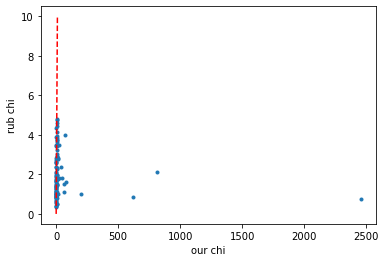

In [87]:
plt.plot(chi_list[-1][:,0],chi_rub[:100][:,0],'.')
plt.xlabel('our chi')
plt.ylabel('rub chi')
plt.plot([0,10],[0,10],'r--')
# plt.xlim((-0.1,0.2))

In [88]:
params_list[-1,:,1]*180/3.1415

array([ 39.255432  ,  35.966297  ,   0.00215869,   0.01601017,
         8.364964  ,   4.298408  , -11.453503  ,   5.1252694 ,
        59.591625  ,  -3.6200335 ,  49.981663  ,  61.49964   ,
        33.412556  ,  30.827463  ,  33.52485   ,  31.513311  ,
        35.040718  ,  31.812841  ,  33.924007  ,  31.571562  ,
        32.78347   ,  62.14736   ,  31.402596  ,  29.381365  ,
        55.553062  ,  33.22238   ,  30.96447   ,  34.19235   ,
        32.660103  ,  30.391956  ,  26.861794  ,  29.985556  ,
        33.383816  ,  -0.0026147 ,  -7.893288  ,  16.372059  ,
        19.772274  ,  13.087407  ,  16.489315  ,  15.313668  ,
        15.113788  ,  24.003693  ,  16.169615  ,  16.617458  ,
        21.981453  ,  -7.187816  ,  14.934572  ,  13.703097  ,
        49.63148   ,  15.57506   ,  15.051662  ,  48.651875  ,
        19.669529  ,  16.808313  ,  15.053849  ,  16.675451  ,
        16.42221   ,  43.742367  ,  44.807636  ,  41.79196   ,
        44.363678  ,  43.882927  ,   7.0131555 ,  44.76

In [89]:
theta[:100,0]*180/3.1415

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([40.799103, 32.7505  ,  6.55946 ,  6.55946 ,  6.55946 ,  6.55946 ,
        6.55946 ,  6.55946 ,  6.55946 ,  6.55946 , 32.3347  , 32.3347  ,
       32.3347  , 32.3347  , 32.3347  , 32.3347  , 32.3347  , 32.3347  ,
       32.3347  , 32.3347  , 32.3347  , 32.3347  , 32.3347  , 32.3347  ,
       32.3347  , 32.3347  , 32.3347  , 32.3347  , 32.3347  , 32.3347  ,
       32.3347  , 32.3347  , 32.3347  , 16.3283  , 16.3283  , 16.3283  ,
       16.3283  , 16.3283  , 16.3283  , 16.3283  , 16.3283  , 16.3283  ,
       16.3283  , 16.3283  , 16.3283  , 16.3283  , 16.3283  , 16.3283  ,
       16.3283  , 16.3283  , 16.3283  , 16.3283  , 16.3283  , 16.3283  ,
       16.3283  , 16.3283  , 16.3283  , 46.5997  , 46.5997  , 46.5997  ,
       46.5997  , 46.5997  , 46.5997  , 46.5997  , 46.5997  , 46.5997  ,
       46.5997  , 46.5997  , 46.5997  , 46.5997  , 46.5997  , 46.5997  ,
       46.5997  , 43.5622  , 43.5622  , 43.5622  , 43.5622  , 43.5622  ,
   

In [90]:
tf.concat([params_list[-1,:,1:2]*180/3.1415,theta[:100,0:1]*180/3.1415],axis=1)

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[ 39.255432  ,  40.799103  ],
       [ 35.966297  ,  32.7505    ],
       [  0.00215869,   6.55946   ],
       [  0.01601017,   6.55946   ],
       [  8.364964  ,   6.55946   ],
       [  4.298408  ,   6.55946   ],
       [-11.453503  ,   6.55946   ],
       [  5.1252694 ,   6.55946   ],
       [ 59.591625  ,   6.55946   ],
       [ -3.6200335 ,   6.55946   ],
       [ 49.981663  ,  32.3347    ],
       [ 61.49964   ,  32.3347    ],
       [ 33.412556  ,  32.3347    ],
       [ 30.827463  ,  32.3347    ],
       [ 33.52485   ,  32.3347    ],
       [ 31.513311  ,  32.3347    ],
       [ 35.040718  ,  32.3347    ],
       [ 31.812841  ,  32.3347    ],
       [ 33.924007  ,  32.3347    ],
       [ 31.571562  ,  32.3347    ],
       [ 32.78347   ,  32.3347    ],
       [ 62.14736   ,  32.3347    ],
       [ 31.402596  ,  32.3347    ],
       [ 29.381365  ,  32.3347    ],
       [ 55.553062  ,  32.3347    ],
       [ 33.22238   ,  32

Text(0, 0.5, 'recon')

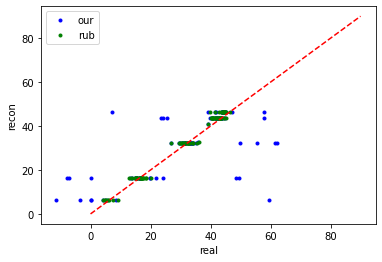

In [91]:
plt.plot(params_list[-1,:,1]*180/3.1415,theta[:100,0]*180/3.1415,'b.',label='our')
plt.plot(recos[:100,0],theta[:100,0]*180/3.1415,'g.',label='rub')
plt.plot([0,90],[0,90],'r--')
plt.legend()
plt.xlabel('real')
plt.ylabel('recon')

Text(0.5, 1.0, 'without CHI_L')

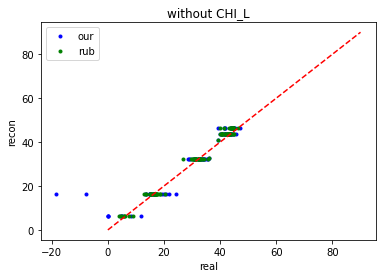

In [53]:
# withot chiL
plt.plot(params_list[-1,:,1]*180/3.1415,theta[:100,0]*180/3.1415,'b.',label='our')
plt.plot(recos[:100,0],theta[:100,0]*180/3.1415,'g.',label='rub')
plt.plot([0,90],[0,90],'r--')
plt.legend()
plt.xlabel('real')
plt.ylabel('recon')
plt.title('without CHI_L')

Text(0, 0.5, 'recon')

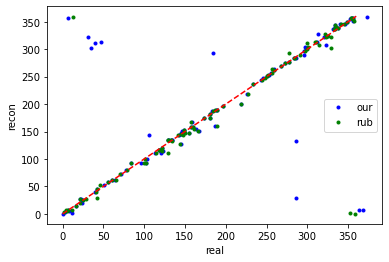

In [40]:
plt.plot(tf.abs(params_list[-1,:,2]*180/3.1415),phi[:100,0]*180/3.1415,'b.',label='our')
plt.plot(recos[:100,1],phi[:100,0]*180/3.1415,'g.',label='rub')
plt.plot([0,360],[0,360],'r--')
plt.legend()
plt.xlabel('real')
plt.ylabel('recon')

In [163]:
# phi 
params_list[-1,:,2]*180/3.1415

array([110.4019   , 185.75807  , 133.50099  , 308.4891   , 380.10236  ,
       216.00056  ,  31.922329 , -11.20899  , 255.7551   , 168.97673  ,
       324.18723  ,  68.490234 , 363.041    , 256.692    , 117.79535  ,
       170.11798  , 288.68396  , 226.74782  ,  11.428991 , 157.28307  ,
       147.83887  ,   0.5012963, 195.5255   , 162.30199  , 341.34412  ,
       149.6957   ,  47.187416 , 281.13858  , 319.6809   ,  95.038734 ,
       126.48585  , 249.18367  ,  23.84545  ,  48.373505 ,   2.3081775,
         6.8112407,   2.4732444, 339.5395   , 366.7993   , 150.68044  ,
       169.88058  ,  56.228306 , 154.15868  , 305.96716  , 142.58405  ,
        62.055786 ,  90.58363  ,  41.235355 ,  -3.1538308, 198.52365  ,
       148.76611  ,   2.0381722, 204.33992  , 262.57465  ,  27.682117 ,
       143.41429  ,  69.60372  , 255.84508  , 194.91487  , 188.95323  ,
       138.45636  , 297.42303  , 314.18585  ,  64.5595   , 173.42926  ,
       246.72592  , 343.33923  , 158.52773  , 343.3629   , 136.7

In [164]:
phi[:100,0]*180/3.1415

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([110.128     , 181.896     , 292.56104   , 132.034     ,
         6.33248   , 110.91699   , 310.731     , 301.68198   ,
        29.718699  , 159.512     , 323.625     , 117.254     ,
       355.848     , 283.80798   , 143.354     , 174.618     ,
       357.13803   , 218.87401   ,  20.1942    , 154.829     ,
       134.927     ,   3.5728102 , 186.847     , 150.76001   ,
       346.152     , 152.153     ,  39.814503  , 277.253     ,
       336.663     , 100.41599   , 114.934     , 261.905     ,
        24.6465    ,  27.35      , 142.953     , 357.52698   ,
       323.05402   , 344.218     , 358.59598   , 133.748     ,
       167.68599   ,  52.4621    , 150.617     , 264.82202   ,
       127.851     ,  92.0858    ,  92.87591   ,  27.479     ,
       312.60098   , 200.86198   , 147.069     ,   1.52536   ,
       326.88797   , 350.592     ,   5.3751903 , 134.526     ,
        91.8993    , 255.911     , 188.47      , 196.22899   ,
       

# Обучение Нейронки

In [49]:
noise_dim=50
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)

In [50]:
detectors_rub[1,:,:,1]

array([[-6.        , -6.        , -6.        , -6.        , -6.        ,
        -6.        ],
       [-6.        , -6.        , -0.542352  ,  0.6625092 , -6.        ,
        -6.        ],
       [-6.        , -6.        , -0.5548644 ,  0.6544056 , -6.        ,
        -6.        ],
       [-6.        , -6.        , -0.5483316 ,  0.6509472 , -6.        ,
        -6.        ],
       [-6.        , -6.        , -6.        ,  0.59666646, -6.        ,
        -6.        ],
       [-6.        , -6.        , -6.        , -6.        , -6.        ,
        -6.        ]], dtype=float32)

In [51]:
class Det2Core(tf.keras.layers.Layer):
#     @tf.function(input_signature=[tf.TensorSpec([None,3])])
    def call(self,det_core,dist=1.2):
        x= tf.cast(tf.repeat(tf.expand_dims(tf.range(5,-1,-1),1),6,axis=1),tf.float32)
        y = tf.cast(tf.repeat(tf.expand_dims(tf.range(5,-1,-1),0),6,axis=0),tf.float32)
        x = tf.expand_dims(x,-1)
        y = tf.expand_dims(y,-1)
        z =tf.zeros_like(x)
        detectors = tf.concat([x,y,z],axis=-1) * dist
#         print(detectors)
#         detectors = tf.repeat(tf.expand_dims(detectors,0),batch,0)
        res = tf.where (det_core == np.array([-6,-6,0]),np.nan, detectors + det_core) 
        print(res[1,:,:,0])
        core = tf.convert_to_tensor(tf.experimental.numpy.nanmean(res,axis=(1,2)))
#         return tf.TensorSpec.from_tensor(core)
        return core
det2core = Det2Core()
det2core(detectors_rub[:2])

tf.Tensor(
[[      nan       nan       nan       nan       nan       nan]
 [      nan       nan 3.1437602 3.126276        nan       nan]
 [      nan       nan 3.1311278 3.1411057       nan       nan]
 [      nan       nan 3.136656  3.1377985       nan       nan]
 [      nan       nan       nan 3.047244        nan       nan]
 [      nan       nan       nan       nan       nan       nan]], shape=(6, 6), dtype=float32)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.1796193 , 2.780812  , 0.03348011],
       [3.123424  , 3.0455685 , 0.04572365]], dtype=float32)>

In [14]:
# ep=199
# generator=tf.keras.models.load_model('../Models/deep_5/save_model/generator/ep'+str(100))
discriminator=tf.keras.models.load_model('../Models/deep_5/save_model/discriminator/ep'+str(100))
# noise = tf.random.normal(shape=(100,50))
# fake_data=generator(noise)#change
# print(tf.math.reduce_mean(discriminator(fake_data)))

# print(tf.math.reduce_mean(discriminator(data[-100:])))

In [15]:
def Conditional_generator(generator,num="",noise_dim=50):
    input_noise=tf.keras.Input(shape=(noise_dim,))
    input_detectors = tf.keras.Input(shape=(6,6,3)) # don't use like input generator
    input_core = det2core(input_detectors)
    input_theta = tf.keras.Input(shape=(1,))
    input_phi = tf.keras.Input(shape=(1,))
    input_courve =tf.keras.Input(shape=(1,))
    input_S800 =  tf.keras.Input(shape=(1,))
    
    input_tensor = tf.keras.layers.concatenate([input_noise,input_core,input_theta,input_phi,input_courve,input_S800])
    noise = tf.keras.layers.Dense(noise_dim)(input_tensor)
    result = generator(noise)
    model= tf.keras.Model([input_noise,input_detectors,input_theta,input_phi,input_courve,input_S800],
                          result,
                          name="Generator_model_{}".format(num))
    return model
cond_generator = Conditional_generator(tf.keras.models.load_model('../Models/deep_5/save_model/generator/ep'+str(100)))
cond_generator.summary()

Model: "Generator_model_"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6, 6, 3)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
det2_core (Det2Core)            (None, 3)            0           input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
___________________________________________________________________________________

# TRAIN

In [16]:
# cd Parameters_all/

In [52]:
max_c=tf.reshape(tf.constant([i[0] for i in norm_params.values()]),(1,1,1,4))
min_c=tf.reshape(tf.constant([i[1] for i in norm_params.values()]),(1,1,1,4))
max_c,min_c

(<tf.Tensor: shape=(1, 1, 1, 4), dtype=float32, numpy=array([[[[445.172,  11.   ,  11.974,   1.   ]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 1, 4), dtype=float32, numpy=array([[[[  0.   , -10.487,  -2.573,   0.   ]]]], dtype=float32)>)

In [53]:
def renorming(data,max_c = max_c,min_c = min_c,log=True):
    data = data*(max_c-min_c) + min_c
#     if (i==0 and log):
#         data = data[:,:,:,i].assign(tf.math.exp(data[:,:,:,i])-1)
#     #         elif (i==1 or i==2):
#     #             data[:,:,:,i]=data[:,:,:,i]#*1e6
    return data

In [54]:
def im_one(i,data,axs):
    signal=data[i,:,:,0]
    real_time=data[i,:,:,1]+data[i,:,:,2]
    mask=data[i,:,:,3]
    sns.heatmap(data[i,:,:,0]*mask,annot=data[i,:,:,0]*mask,ax=axs[i,0],vmin=0.0, vmax=1.0)
    sns.heatmap(real_time*mask,annot=real_time*mask,ax=axs[i,1],vmin=-1.0, vmax=1.0)

def image_signal(data,fake=None,dir_name=None,ep='not_ep'):
    n=data.shape[0]
    if (fake is None):
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(10,n*5))
#         Parallel(n_jobs=-1)(delayed(im_one)(i,data,axs) for i in range(n))
        for i in range(n):
            im_one(i,data,axs)
            axs[i,0].set_title(f'number {str(i)}')
                           
        fig.suptitle('only real')
    else:
        fig, axs = plt.subplots(nrows=n, ncols=4, figsize=(10*2,n*5))
        data_after = renorming(data)
        data_after = tf.where(tf.cast(tf.expand_dims(data_after[:,:,:,-1],axis=-1),tf.bool),data_after[:,:,:,:],np.nan)
        fake_after = renorming(fake)
        fake_mask = tf.cast(tf.where(tf.cast(fake_after[:,:,:,3:4]>0.5,tf.bool),1,0),tf.float32)
        fake_after *= fake_mask
        fake_after = tf.where(tf.cast(tf.expand_dims(fake_after[:,:,:,-1],axis=-1),tf.bool),fake_after[:,:,:,:],np.nan)
        for i in range(n):
            sns.heatmap(data_after[i,:,:,0],annot=data_after[i,:,:,0],ax=axs[i,2],fmt=".1f")
            sns.heatmap(data_after[i,:,:,1],annot=data_after[i,:,:,2],ax=axs[i,3],fmt=".2f")
            
            
            sns.heatmap(fake_after[i,:,:,0],annot=fake_after[i,:,:,0],ax=axs[i,0],fmt=".1f")
            sns.heatmap(fake_after[i,:,:,1],annot=fake_after[i,:,:,2],ax=axs[i,1],fmt=".2f")
        fig.suptitle('fake     /    real')
    if dir_name:
        plt.savefig("{}/save_images/epoch{}.png".format(dir_name,ep))
        plt.close()
        
def images(cond_generator,num, data_all,
           noise_dim=noise_dim, dir_name='', ep='not_ep'):
    shape = (6,6,4)
    rand=np.random.choice(np.arange(len(data_all)),num)
    data_for_plot=np.zeros((num,shape[0],shape[1],shape[2]))
    det_l = np.zeros((num,6,6,3))
    theta_l = np.zeros((num,1))
    phi_l = np.zeros((num,1))
    courve_l = np.zeros((num,1))
    S800_l = np.zeros((num,1))
    for i in range(num):
        data, det, theta, phi, courve, S800 = data_all[rand[i]]
#         print(data.shape, det, theta, phi, courve, S800)
        data_for_plot[i]=data
        det_l[i] = det
        theta_l[i] = theta
        phi_l[i] = phi
        courve_l[i] = courve
        S800_l[i] = S800
    noise = tf.random.normal(shape=(num,noise_dim))
    fake=cond_generator([noise,det_l, theta_l, phi_l, courve_l,S800_l])
    fake = np.array(fake)
    image_signal(data_for_plot,fake=fake,dir_name=dir_name,ep=ep)

In [55]:
# images(cond_generator,2, test)

In [56]:
def discriminator_loss(real_output, fake_output):
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def reco_loss(real_time, detectors,t0,theta,phi,courve,mask,S800):
    return reco.chiT_by_param(real_time, detectors,t0,theta,phi,courve,mask,S800)
def loss_time(data,kof=10,res=tf.Variable(0,dtype=tf.float32)):
#     res=tf.Variable(0,dtype=tf.float32)
    for i in range(data.shape[0]):
        data_n=tf.where(tf.cast(tf.expand_dims(data[i,:,:,3],axis=-1),tf.bool),data[i],np.nan)
        arg=tf.where(data_n[:,:,0] == tf.math.reduce_max(data[i,:,:,0]))[0]
        time=data_n[arg[0],arg[1],2]
        min_time=tf.math.reduce_min(tf.where(tf.math.is_nan(data_n[:,:,2]),np.inf,data_n[:,:,2]))
        res=res+time-min_time
    return(res/data.shape[0]*kof)
        
#     max_active_time=
def generator_loss(fake_output):
#     return loss_function(tf.ones_like(fake_output), fake_output)
    return -tf.reduce_mean(fake_output)

def gradient_penalti(batch,real_data,fake_data):
#   alpha = tf.random.normal([batch, 1], 0.0, 1.0)
#   diff = fake_data - real_data
#   interpolated = real_data + alpha * diff
    epsilon=tf.random.uniform(shape=(batch,1,1,1),dtype=tf.dtypes.float32)
#     print(epsilon)
    interpolated=real_data-epsilon*(real_data-fake_data)# вычисление x^ как в статье
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred=discriminator(interpolated,training=True)  # D(x^)
    grads = gp_tape.gradient(pred, [interpolated])[0]# because list
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp    
@tf.function
def train_step_WGAN(labda,batch,real_data,weight_gp,weight_corr):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    real_time = real_data[:,:,:,1:2] +real_data[:,:,:,2:3]
    mask = real_data[:,:,:,3:4]
    t0=tf.constant(0, dtype=tf.float32)
    for i in range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=generator(noise)#change
#             print('f')
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)+weight_gp*gp # critic loss include GP
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))
  #learning generator
    noise = tf.random.normal(shape=(batch,noise_dim))
    with tf.GradientTape() as gr:
        fake_data=generator(noise)
        fake_predict=discriminator(fake_data)
        gen_loss=generator_loss(fake_predict)
        gen_loss=gen_loss+ loss_time(fake_data) #+ reco_loss(fake_time, detectors,t0,theta,phi,courve,mask)
    g_grad=gr.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grad, generator.trainable_variables))
    return (gen_loss,disc_loss,loss_time(fake_data))
@tf.function
def train_step_COND_WGAN(real_data, detectors, t0, theta, phi, courve, S800,
                         batch,labda=5,weight_gp=10):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    real_time = real_data[:,:,:,1:2] +real_data[:,:,:,2:3]
    mask = real_data[:,:,:,3:4]
    t0=tf.constant(0, dtype=tf.float32)
    for i in tf.range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=cond_generator([noise,detectors, theta, phi, courve,S800])#change
#             print('f')
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)+weight_gp*gp # critic loss include GP
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))
  #learning generator
    noise = tf.random.normal(shape=(batch,noise_dim))
    with tf.GradientTape() as gr:
        fake_data=cond_generator([noise,detectors, theta, phi, courve,S800])
        fake_predict=discriminator(fake_data)
        
        gen_loss=generator_loss(fake_predict)
        gen_loss=gen_loss+ loss_time(fake_data)
        
        fake_data_renorm = renorming(fake_data,log=False)
        fake_time= fake_data_renorm[:,:,:,1:2] +fake_data_renorm[:,:,:,2:3]
        #renorming
        theta = renorm_params(theta,theta_t,theta_b)
        phi = renorm_params(phi,phi_t,phi_b)
        courve = renorm_params(courve,courve_t,courve_b)
        S800 = renorm_params(S800,S800_t,S800_b)
        
        gen_loss=gen_loss+ reco_loss(fake_time, detectors*6,t0,theta,phi,courve,mask,S800)
    g_grad=gr.gradient(gen_loss,cond_generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grad, cond_generator.trainable_variables))
    return (gen_loss,disc_loss)
def func_chunks_generators(lst, n):
    '''передается масив и число.масив разбивается на масивы длиной не более n
    пример func_chunks_generators([1,2,3,4,5], 3) -> [[1,2,3],[4,5]]
    lst- масив
    n- число, пределяющее максимальную длину'''
    l=[]
    for i in range(0, len(lst), n):
         l.append(lst[i : i + n])
    return(l)

In [57]:
batch=2
epochs=250
ep_start=0
g_list=[]
d_list=[]
time_list=[]
def train_WGAN(epochs,train_data,test_data,batch,dir_name):
    lamda = tf.constant(5,dtype=tf.float32)
    weight_gp = tf.constant(10,dtype=tf.float32)
    if not(os.path.exists(dir_name)):
        os.mkdir(dir_name)
        os.mkdir(os.path.join(dir_name,'save_images'))
        os.mkdir(os.path.join(dir_name,'save_model'))
        os.mkdir(os.path.join(dir_name,'save_model/discriminator'))
        os.mkdir(os.path.join(dir_name,'save_model/generator'))
#     data, detectors_rub, theta, phi, courve, S800 = train_data
    data = [i[0] for i in train_data]
    detectors_rub = [i[1] for i in train_data]
    theta = [i[2] for i in train_data]
    phi = [i[3] for i in train_data]
    courve = [i[4] for i in train_data]
    S800 = [i[5] for i in train_data]
    train_data = func_chunks_generators(data, batch)
    detectors_rub = func_chunks_generators(detectors_rub, batch)
    t0=tf.constant(0,dtype=tf.float32)
    theta = func_chunks_generators(theta, batch)
    phi = func_chunks_generators(phi, batch)
    courve = func_chunks_generators(courve, batch)
    S800 = func_chunks_generators(S800, batch)
    for j in tqdm_notebook(range(ep_start,epochs),'ep'):
        for num in tqdm_notebook(range(0,len(train_data)),f'epoch num{j}'):
            step_data=tf.Variable(train_data[num],dtype = tf.float32)
            step_theta =tf.Variable(theta[num],dtype = tf.float32)
            step_phi = tf.Variable(phi[num],dtype = tf.float32)
            step_courve = tf.Variable(courve[num],dtype = tf.float32)
            step_detectors_rub = tf.Variable(detectors_rub[num],dtype = tf.float32)
            step_S800 = tf.Variable(S800[num],dtype = tf.float32)
            all_data = (step_data,step_detectors_rub,t0,step_theta,step_phi,step_courve, step_S800)
#             train_step_WGAN(labda=5,batch=2,real_data=step_data,weight_gp=10,weight_corr=1)
            g,d=train_step_COND_WGAN(step_data,step_detectors_rub,t0,step_theta,step_phi,step_courve, step_S800,
                                     batch = tf.constant(step_data.shape[0]),labda=lamda,weight_gp=weight_gp)
            d_list.append(d)
            g_list.append(g)
#             time_list.append(t)
        if (j % 10 == 0):
            images(cond_generator,num=10, data_all=test,
                   noise_dim=noise_dim,dir_name=dir_name,ep=j)
            discriminator.save("{}/save_model/discriminator/ep{}".format(dir_name,j))
            cond_generator.save("{}/save_model/generator/ep{}".format(dir_name,j))
            plt.close()
dir_name = '../Models/Conditional+Phys_loss'
train_WGAN(epochs,train,test,batch,dir_name=dir_name)

plt.close()
plt.figure()
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.plot(time_list[5000::100],'b')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)
plt.savefig(os.path.join(dir_name,'loss.jpg'))
df=pd.DataFrame({'disc':d_list,'gen':g_list,"time":time_list})
df.to_csv("{}/loss.csv".format(dir_name))

KeyboardInterrupt: 

In [ ]:
type(train)

NameError: name 'dir_name' is not defined

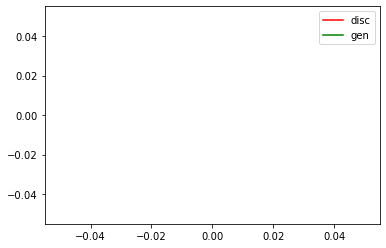

In [92]:
plt.figure()
plt.plot(d_list,'r')
plt.plot(g_list,'g')
# plt.plot(time_list[5000::100],'b')
plt.legend(['disc','gen','time'])
# plt.ylim(-5,5)
plt.title(dir_name)
# plt.savefig(os.path.join(dir_name,'loss.jpg'))

In [41]:
df=pd.DataFrame({'disc':d_list,'gen':g_list,"time":time_list})
df.to_csv("{}/loss.csv".format(dir_name))

Text(0.5, 1.0, 'deep_5_+loss')

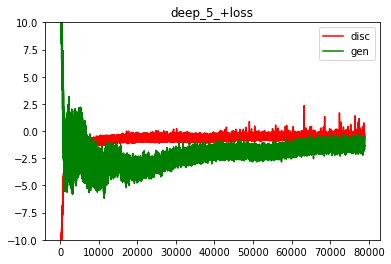

In [45]:
plt.plot(d_list,'r')
plt.plot(g_list,'g')
plt.legend(['disc','gen'])
plt.ylim(-10,10)
plt.title(dir_name)
# plt.savefig(os.path.join('deep_7_2','loss.jpg'))

Text(0.5, 1.0, 'deep_res')

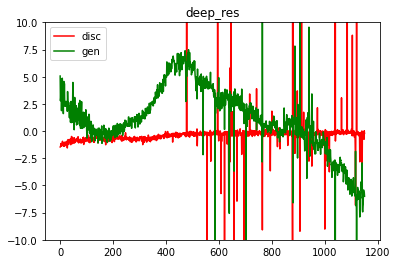

In [45]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
plt.ylim(-10,10)
plt.title(dir_name)
# plt.savefig(os.path.join('deep_7_2','loss.jpg'))

Text(0.5, 1.0, 'deep_7')

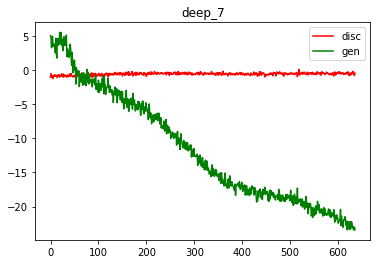

In [25]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)

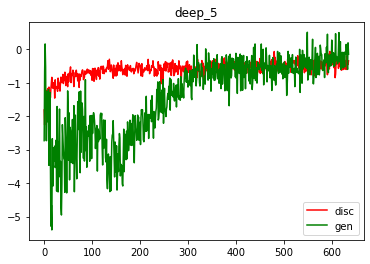

In [27]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)
plt.savefig(os.path.join(dir_name,'loss.jpg'))

  0%|          | 8/3000 [00:00<01:36, 30.86it/s]


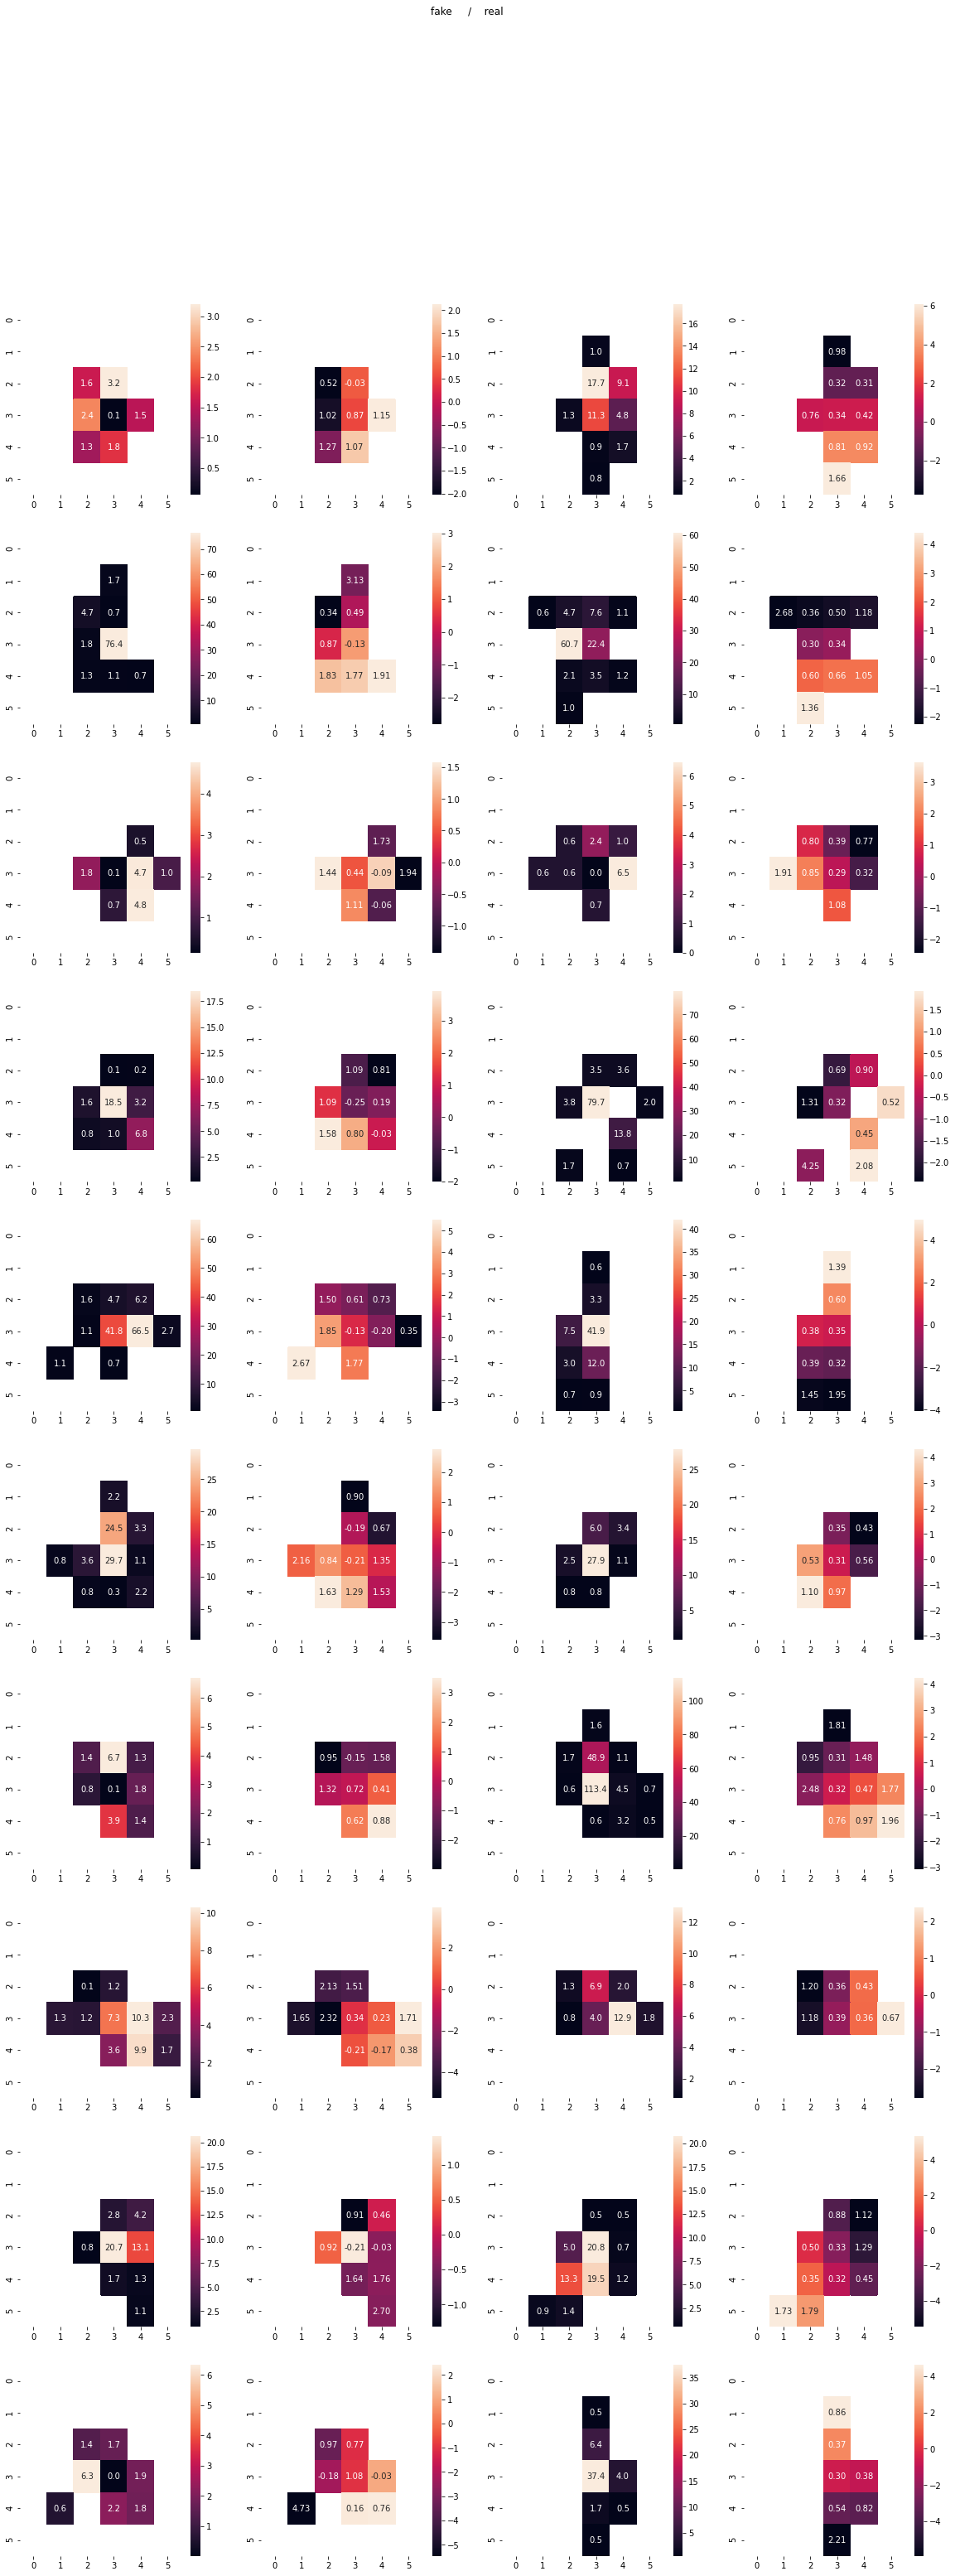

In [30]:
ep=199
generator=tf.keras.models.load_model('deep_5/save_model/generator/ep'+str(ep))
discriminator=tf.keras.models.load_model('deep_5/save_model/discriminator/ep'+str(ep))
def Residual_loss(data_true, data_fake):
    return tf.reduce_mean( tf.math.abs(data_true - data_fake),axis=(1,2,3))# сделать универсально
def Discriminator_loss(data_true, data_fake,discriminator):
    real_pred=discriminator(data_true)
    fake_pred=discriminator(data_fake)
    return tf.math.abs( real_pred - fake_pred)
loss_L=[]
def find_noise(generator,discriminator,image,noise_dim,alpha=1.2,k_rd=0.0001):
#         global loss_L
#     print(image.sha)
    global loss_L
    loss_befor=1000000000
    k=0
    noise = tf.random.normal(shape=(image.shape[0],noise_dim))
    noise_befor=tf.identity(noise)
    for i in tqdm.tqdm(range(3000)):
        with tf.GradientTape() as tape:
            tape.watch(noise)
            fake=generator(noise)
            loss=Residual_loss(image, fake)
            loss_disc=Discriminator_loss(image, fake,discriminator)*k_rd
            Loss=tf.reshape(loss,(-1,1))+loss_disc
            loss_L.append(Loss)
        g_grad=tape.gradient(Loss,noise)
        noise=noise-alpha*g_grad
        if tf.math.reduce_mean((loss_befor-Loss))<0.005*tf.math.reduce_mean(Loss):
            k+=1
            if k>7:
                break
        else:
            loss_befor=Loss
            k=0
            
    return (noise,noise_befor)
def images_define(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep'):
    rand=np.random.choice(np.arange(data.shape[0]),num)
    data_for_plot=np.zeros((num,shape[0],shape[1],shape[2]))
    fake=np.zeros((num,shape[0],shape[1],shape[2]))
    for i in range(num):
        data_for_plot[i]=data[rand[i]]
        noise = find_noise(generator,discriminator,np.array([data_for_plot[i]]),noise_dim,alpha=1.2,k_rd=0.0001)[0]
        fake[i]=generator(noise)
    image_signal(data_for_plot,fake=fake,dir_name=dir_name,ep=ep)

images_define(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep')
